# Context
This tutorial on Spiking Neural Networks (SNNs), applied to a sound localization task, is an extensively annotated version of [the excellent tutorial created by Dan Goodman for the 2022 Cosyne Conference](https://neural-reckoning.github.io/cosyne-tutorial-2022/).

Expanding on the original Cosyne tutorial, I have developed this version specifically for a computational project as paort of a neuroscience lecture at the master’s level in Paris that I started together with [Marcus Ghosh](https://neural-reckoning.org/marcus_ghosh.html). While the core code remains unchanged, this version includes additional annotations, additional detailed explanations, and additional plotting to improve accessibility and enhance understanding for students.

As a starting point, I highly recommend watching the comprehensive video lecture delivered by Dan Goodman during the Cosyne workshop. [Watch this video lecture on YouTube.](https://www.youtube.com/watch?v=GTXTQ_sOxak)  <br><br><br>



[Volker Bormuth](https://www.labojeanperrin.fr/?article6)  
Assistant Professor  
Laboratoire Jean Perrin   
Sorbonne Universiy  
Paris, France  

---
---
# Introduction
---
---

Animals localise sounds by detecting location- or direction-specific cues in the signals that arrive at their ears. Some of the most important sources of cues (although not the only ones) come from differences in the signals between two ears, including both level and timing differences. Respectively, termed interaural level difference (ILD) and interaural timing difference (ITD). In some cases humans are able to detect arrival time differences as small as 20 μs.

The classic model of ITD sensitivity is the delay line model of Jeffress ([1948](https://psycnet.apa.org/doiLanding?doi=10.1037%2Fh0061495) ) in which an array of binaural coincidence detector neurons receive inputs from the two ears with different delays. When a neurons’ delays exactly match the acoustic delays induced by the sound location, it will be maximally active. Therefore, the identity of the most active neuron indicates the direction of the sound.







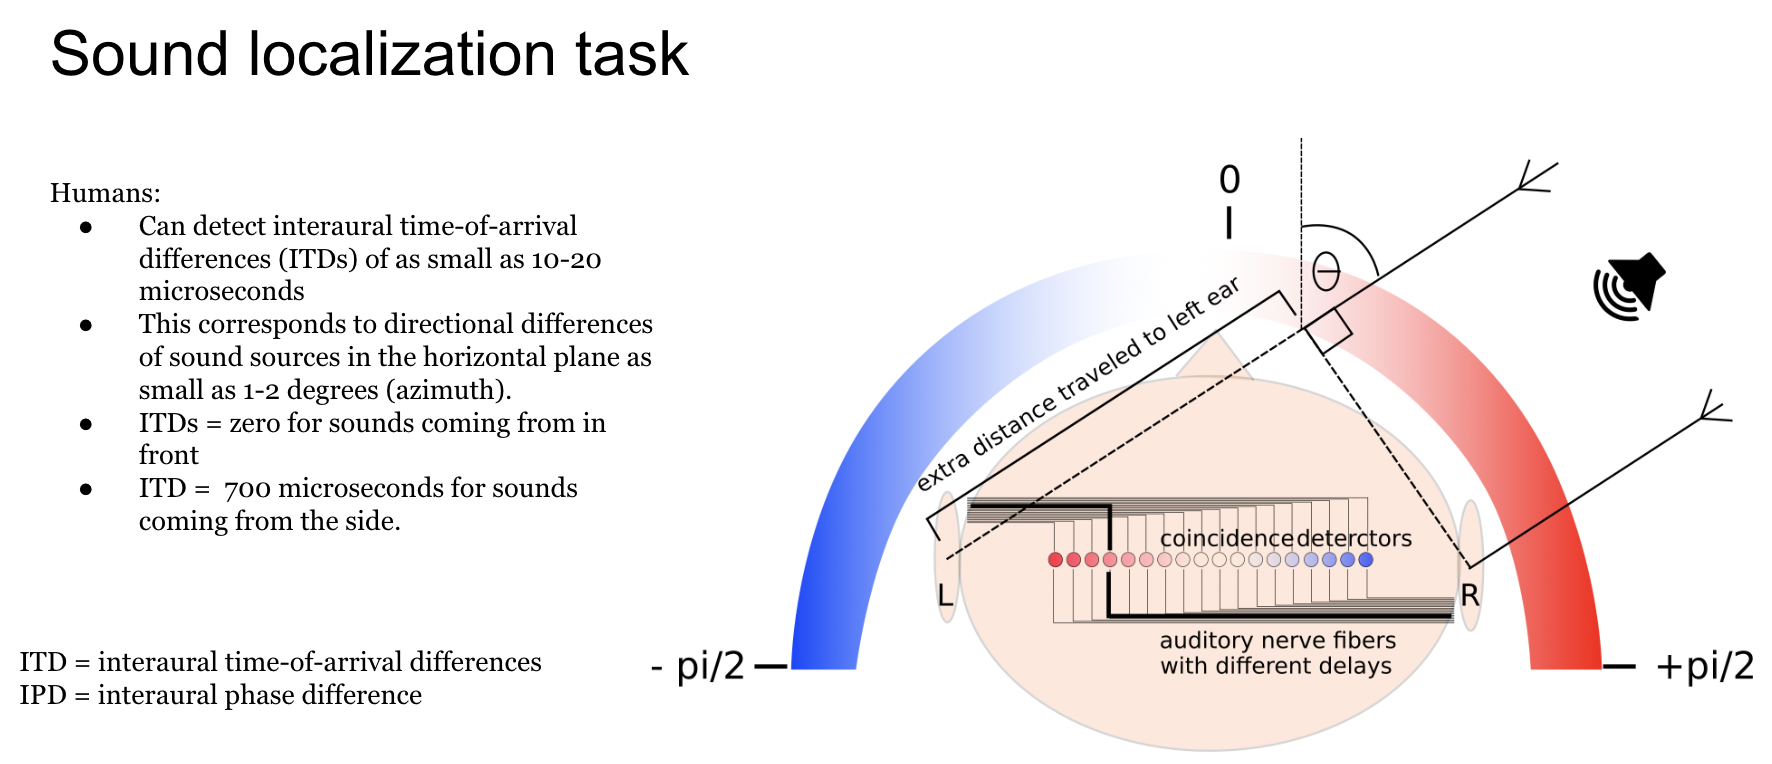

A simple sound localization task is defined, and input/output data for it are generated.





The task is to estimate the ITD of a pure tone (sine wave) at a fixed frequency. This is equivalent to estimating the interaural phase difference (IPD) since the ITD is ambiguous for a sine wave.

An SNN model is defined, and trained on this data, using surrogate gradient descent.

The model consists of three layers. First, a layer of spiking input neurons which fire spikes according to a Poisson process with a time-varying rate determined by the input stimulus. This layer is divided into two subpopulations corresponding to the two ears, with signals to one ear delayed with respect to the other. Each neuron within a subpopulation has a different phase delay. Next, comes a single hidden layer of leaky integrate-and-fire (LIF) neurons, and an output layer of leaky, non-spiking neurons. Each output neuron is associated to a particular IPD, and the estimated IPD of the model is the identity of the most active output neuron.

The input neurons are all-to-all connected to the layer of hidden neurons via a trainable weight matrix. In this way, during training the model is free to select the neurons with the appropriate phase delays to generate the desired properties for the hidden layer neurons. This lets the model learn to make use of delays without having to directly implement trainable delays, as this is a challenging problem

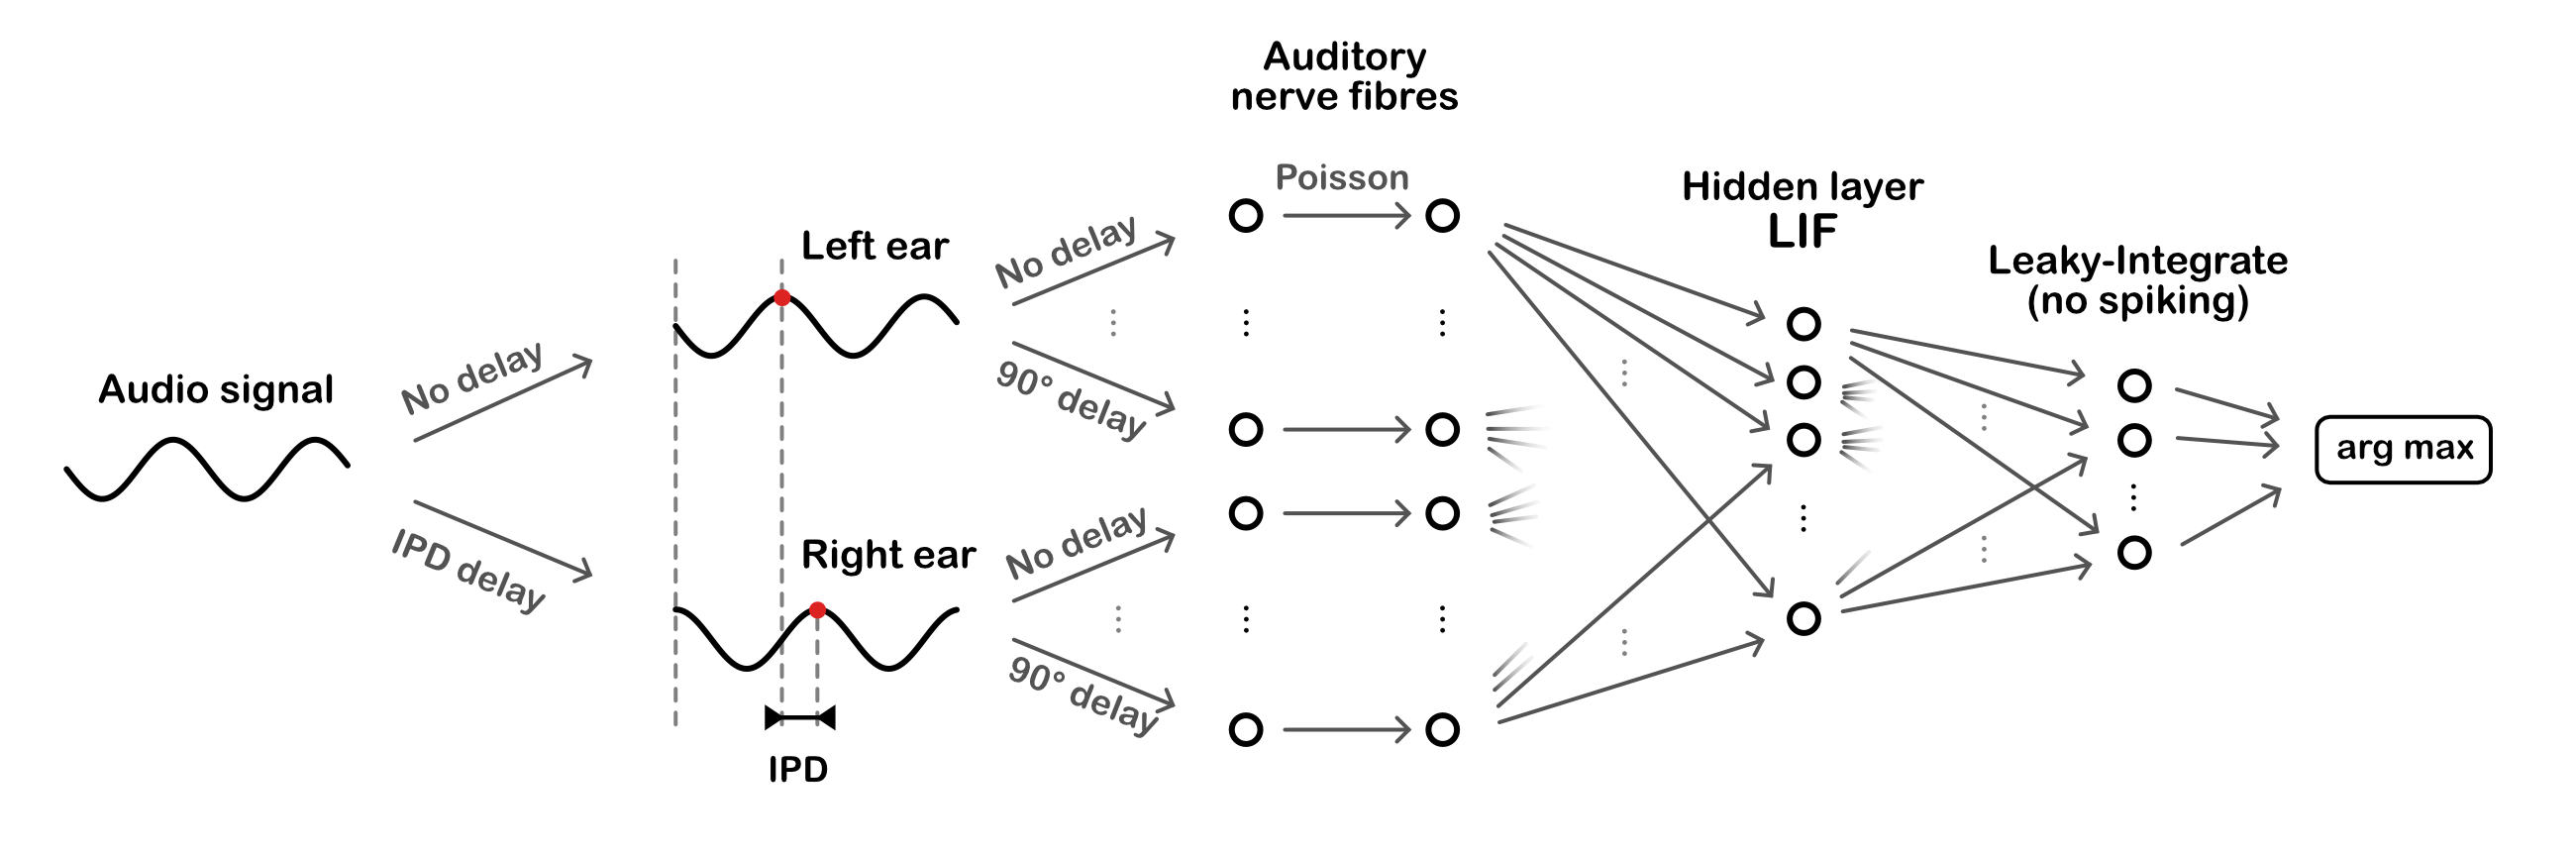

# Our objective:


You will define a project and will play with the model to investigate ow to improve the performance of the network?

Some project ideas for you:

- Change time constant
- Mean or max of output neurons membrane potential
- Heterogeneous time constants
- Change number of hidden units
- Only positive weights
- Adaptive thresholds
- What is better, to use the mean or the max of the output neurons membrane potential time variation?
…

- Can we understand what the network is doing?
Ablate neurons after training and see how this affects the test performance


---
---
# Before Starting: Setting Up Your Environment
---
---


1. Download a copy of this notebook to
your personal google drive
In the Colab menue select:

  "Files" -> "Save a copy in Drive"

  This will create a folder "Colab Notebooks" where the notebook will be saved.

  you can locate where this copy was saved in your dirve:
  
  "Files" => "Locate in Drive"

  Now you can rename the located file and move it to a location of your choice in your google drive

2. Close the original notebook




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


  To check if your google drive is mounted

In [ ]:
import os

# Check if Google Drive is mounted
if os.path.exists('/content/drive'):
    print("Google Drive is already mounted.")
else:
    print("Google Drive is not mounted. Please execute the mount command.")

Google Drive is already mounted.


  Create a plot and save it into your Google Colab virtual workspace. Note this workspace will be deleted when you exit Google Colab.

  In left menue click on the folder symbole. You will see the example_plot.png

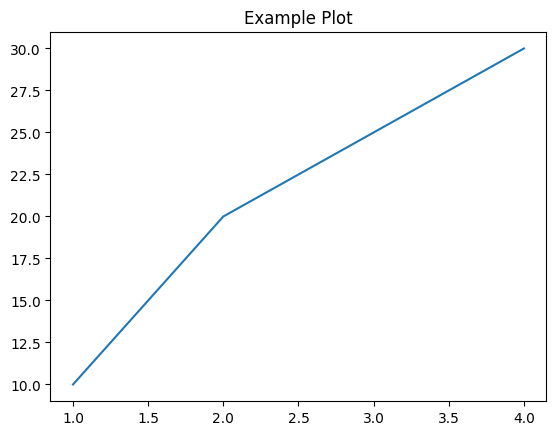

In [ ]:
import matplotlib.pyplot as plt

# Example plot
x = [1, 2, 3, 4]
y = [10, 20, 25, 30]
plt.plot(x, y)
plt.title("Example Plot")

# Save the plot as an image file
plt.savefig('example_plot.png')
plt.show()

  Now copy example_plot.png to you Google Drive:

  Note: You have to change adpat the file path after /content/drive/ to define where you want to save your figures.

In [ ]:
!cp example_plot.png "/content/drive/My Drive/Mini-Project_ColabNotebooks/SBCP_2024/Results_Figures"

  Check if it was well copied

In [ ]:
!ls "/content/drive/My Drive/Mini-Project_ColabNotebooks/SBCP_2024/Results_Figures"

example_plot.png  Proj_EnvelopePower.png


---
---
# Let's start: Run the notebook
---
---


In [ ]:
# Import necessary libraries
import os  # Provides functionalities to interact with the operating system (e.g., file management).
import numpy as np  # Used for numerical computations and working with arrays.
import matplotlib.pyplot as plt  # For creating visualizations and plots.
from matplotlib.gridspec import GridSpec  # To create complex subplot layouts.
from matplotlib.colors import ListedColormap

import torch  # PyTorch library for machine learning and deep learning.
import torch.nn as nn  # PyTorch module for building neural network layers.

# Specify the default data type for PyTorch tensors
dtype = torch.float  # Setting the default data type to 32-bit floating point.

# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")  # If a GPU is available, set PyTorch to use it.
else:
    device = torch.device("cpu")  # Otherwise, default to using the CPU.

# Flag to indicate whether the current environment is resource-constrained
my_computer_is_slow = True  # Set this to True if using a slower system, like Google Colab, to optimize resource usage.

# Importing the Python Debugger module
import pdb  # The built-in Python Debugger, used for step-by-step debugging of code.

# Importing pandas for data manipulation and analysis
import pandas as pd  # A powerful library for working with structured data, such as DataFrames and Series.

## Generation of input signals

### Introduction to Input Signal Generation

The following function creates a set of auditory stimuli that can be used for **training or testing**. These stimuli are modeled based on interaural differences between two ears, capturing the essence of how the auditory system processes spatial sound localization cues. Below is a detailed explanation of the structure and logic behind the signal generation process.

---

#### **Key Components of the Stimuli**

##### **1. Two Ears**
- The simulation involves **two ears** (labeled `0` and `1` in the code).
- Ear 1 receives a delayed version of the signal based on a given **Interaural Phase Difference (IPD)**, denoted as $\alpha$ in equations (referred to as `ipd` in the code).

---

##### **2. The Base Signal**
- The base auditory signal is a **sine wave**, made positive for firing rate modulation:
  \[
  \frac{1}{2}(1 + \sin(\theta))
  \]
  - $\theta$ represents the phase angle for each neuron at each time step.
  - This signal is then modulated to generate Poisson spike trains for each auditory nerve fiber.

---

##### **3. Auditory Nerve Fibers (ANFs)**
- Each ear is connected to **$N_a$ auditory nerve fibers** (referred to as `anf_per_ear` in the code).
- Each ANF generates **Poisson spike trains** at an instantaneous firing rate proportional to the base signal.
- These spike trains are **independent** across neurons, introducing natural variability.

---

##### **4. Phase Delays Across Neurons**
- To make the simulation biologically realistic, each auditory nerve fiber is assigned a unique **phase delay**. These delays:
  - Are uniformly distributed between $0$ and $\pi/2$ for neurons within each ear.
  - Allow differences between the two ears to cover the full range of possible IPDs, from $-\pi/2$ to $\pi/2$.

The phase angle for neuron $j$ in ear $i \in \{0, 1\}$ at time $t$ is computed as:
$$
\theta = 2\pi f t + i \cdot \alpha + j \cdot \frac{\pi}{2N_a}
$$
Where:
- $f$ is the signal frequency.
- $\alpha$ is the IPD applied to ear 1.
- $j \cdot \frac{\pi}{2N_a}$ is the phase delay for the $j$th neuron.

---

##### **5. Poisson Spike Generation**
- Each auditory nerve fiber generates Poisson spike trains based on a **modulated firing rate**:
$$
R(t) = R_\mathrm{max} \left( \frac{1}{2}(1 + \sin(\theta)) \right)^k
$$
Where:
- $R_\mathrm{max}$ (`rate_max`) is the **maximum firing rate**.
- $k$ (`envelope_power`) sharpens the envelope of the firing rate.
- Higher values of $R_\mathrm{max}$ and $k$ make the problem easier to solve because the firing patterns become more distinct.

---

#### **Output Structure**

The functions return the following arrays:

1. **`ipd`**:
   - A 1D array of length `num_samples` representing the true IPD for each stimulus.

2. **`spikes`**:
   - A 3D binary array of shape `(num_samples, duration_steps, 2 * anf_per_ear)`, where:
     - `num_samples`: The number of generated stimuli.
     - `duration_steps`: The number of time steps in the stimulus.
     - `2 * anf_per_ear`: Total number of auditory nerve fibers (including both ears).

---

#### **Simplified Explanation**

1. For **each ear**, the function generates a **delayed signal** based on the IPD and the phase delay for each neuron.
2. The **spike trains** are computed independently for each neuron, following Poisson statistics.
3. The resulting **binary spike array** represents the auditory nerve responses over time, for each IPD and ear.

---

#### **Visualizing the Stimulus Architecture**

Here’s a diagram that provides an overview of the stimuli generation process:

![Stimuli architecture](https://github.com/neural-reckoning/cosyne-tutorial-2022/blob/main/arch-stimuli.png?raw=1)

---

#### **What to Experiment With**
- Adjust **$R_\mathrm{max}$** and **$k$** (`rate_max` and `envelope_power`) to observe their effect on the signal sharpness and the ease of classification.
- Explore how different IPDs affect the spike patterns for the two ears, particularly in relation to the phase delays introduced by the auditory nerve fibers.

By understanding these parameters, you can better interpret the generated spike trains and their relevance to spatial sound localization.

### The data generation function

In [ ]:
# We use the following constants to make equations look nicer below
second = 1
ms = 1e-3
Hz = 1

# Stimulus and simulation parameters
dt = 1*ms            # large time step to make simulations run faster for tutorial
anf_per_ear = 100    # number of auditory nerve fibers connected to each ear with independent noise
envelope_power = 2   # higher values make sharper envelopes. Easier by eye => But does the network perform better ?
rate_max = 600*Hz    # maximum Poisson firing rate
f = 20*Hz            # stimulus frequency
duration = .1*second # stimulus duration
duration_steps = int(np.round(duration/dt))  # number of simulation steps
input_size = 2*anf_per_ear

# Generate an input signal (spike array) from array of true IPDs
def input_signal(ipd, envelope_power=envelope_power):
    """
  Generate a Poisson spike train based on an input Interaural Phase Difference (IPD) array
  and the delays imposed by the individual auditory nerve fibers.

    Parameters
    ----------
    ipd : array-like
        An array of true Interaural Phase Differences (IPD). Shape: (num_samples,)
        Represents the angular difference in the phase of sound waves reaching the two ears.
    envelope_power : float, optional
        A parameter controlling the strength of the signal envelope, which modulates
        the spike train generation. Default value is the globally defined `envelope_power`.
    Returns
    -------
    spikes : ndarray
        A binary array indicating spike occurrences, shaped (num_samples, duration_steps, 2*anf_per_ear).
        `spikes[i, j, k]` is 1 if a spike occurred at the jth time step for the ith IPD in the kth auditory nerve fiber,
        and 0 otherwise.

    Notes
    -----
    - The function first calculates an array of phases (`phi`) to define the sinudoidal auditory stimulus and adds a random
    phase offset because we want that the system learns to infer the angular location of the sound source indepent of its distance
    to the source.
    - An array of theta values is initialized that will hold the transformed phi values according to the phase delay  imposed by the
    individual auditory nerve fibers and the ipd between the two ears.
    - Different phase delays, ranging from 0 to pi/2, are calculated and added with the ipd value to generate theta.
    - Poisson spikes are generated based on the theta values and a sinusoidal modulation of the firing rate.
    - The spikes are returned as a binary array, indicating the occurrence of spikes across auditory nerve fibers and time.
  """
    num_samples = len(ipd) # corresponds to the number of different locations of the source in the data set

    T = np.arange(duration_steps)*dt # array of times over which the auditory signal is constructed
    phi = 2*np.pi*(f*T) #+ 2*np.pi*np.random.rand() # array of phases corresponding to those times with random offset.
    # The random offset ensures that the system learns to infer the angular location of the sound source indepent of its distance
    # to the source.

    phase_delays = np.linspace(0, np.pi/2, anf_per_ear) # array of phase delays introduced by the auditory nerve fibers.
    # For each ear, we have anf_per_ear different phase delays from 0 to pi/2 so
    # that the differences between the two ears can cover the full range from -pi/2 to pi/2

    theta = np.zeros((num_samples, duration_steps, 2*anf_per_ear)) # 3D array that holds the spike pattern of all auditory nerve fibers for all the interaural phase difference in the data set.
    # num_samples = number of different IPD values in our data set
    # duration_step = number of time points in our auditory signal
    # 2*anf_per_ear = total number of auditory nerve fibers

    # Now we set up these theta values. Some numpy vectorisation logic using broadcasting to implements the idea in the text above.
    theta[:, :, :anf_per_ear] = phi[np.newaxis, :, np.newaxis]+phase_delays[np.newaxis, np.newaxis, :]
    theta[:, :, anf_per_ear:] = phi[np.newaxis, :, np.newaxis]+phase_delays[np.newaxis, np.newaxis, :]+ipd[:, np.newaxis, np.newaxis]

    # now generate Poisson spikes at the given firing rate as in the previous notebook
    spikes = rate_max*dt*(0.5*(1+np.sin(theta)))**envelope_power > np.random.rand(num_samples, duration_steps, 2*anf_per_ear)
    return spikes, theta

# Generate some true IPDs from (-pi/2, pi/2) and corresponding spike arrays
def random_ipd_input_signal(num_samples, envelope_power=envelope_power, tensor=True):
    """
    Generate random Interaural Phase Differences (IPDs) and then corresponding spike arrays using
    the function input_signal(idp).

      The function generates `num_samples` IPDs, uniformly distributed in the range (-pi/2, pi/2).
      It then generates corresponding spike arrays using the `input_signal` function.
      Optionally, IPDs and spike arrays can be converted to PyTorch tensors.

      Parameters
      ----------
      num_samples : int
          The number of IPD samples to generate.
      envelope_power : float, optional
          A parameter controlling the strength of the signal envelope, which modulates
          the spike train generation. Default value is the globally defined `envelope_power`.

      tensor : bool, optional
          If True, converts the IPDs and spike arrays to PyTorch tensors before returning them.
          If False, they are returned as NumPy arrays. Default is True.

      Returns
      -------
      ipd : ndarray or Tensor
          An array of randomly generated IPDs. Shape: (num_samples, ).
          Returned as a PyTorch tensor if `tensor` is True, otherwise as a NumPy array.
      spikes : ndarray or Tensor
          A binary array indicating spike occurrences along time, generated by `input_signal` based on `ipd`.
          Returned as a PyTorch tensor if `tensor` is True, otherwise as a NumPy array.
          Shaped: (num_samples, duration_steps, 2*anf_per_ear)

      Notes
      -----
      - Ensure that the `input_signal` function is defined in your environment as it is called within this function.
      - If `tensor` is True, ensure that PyTorch is installed and configured in your environment.

      Examples
      --------
      >>> ipd, spikes = random_ipd_input_signal(50, tensor=False)
      >>> print(ipd.shape, spikes.shape)
      (50,) (50, duration_steps, 2*anf_per_ear)
  """
    ipd = np.random.rand(num_samples)*np.pi-np.pi/2 # uniformly random in (-pi/2, pi/2)
    spikes, theta = input_signal(ipd)
    if tensor:
        ipd = torch.tensor(ipd, device=device, dtype=dtype)
        spikes = torch.tensor(spikes, device=device, dtype=dtype)
    return ipd, spikes, theta



#### Test the data generation function and plot some examples

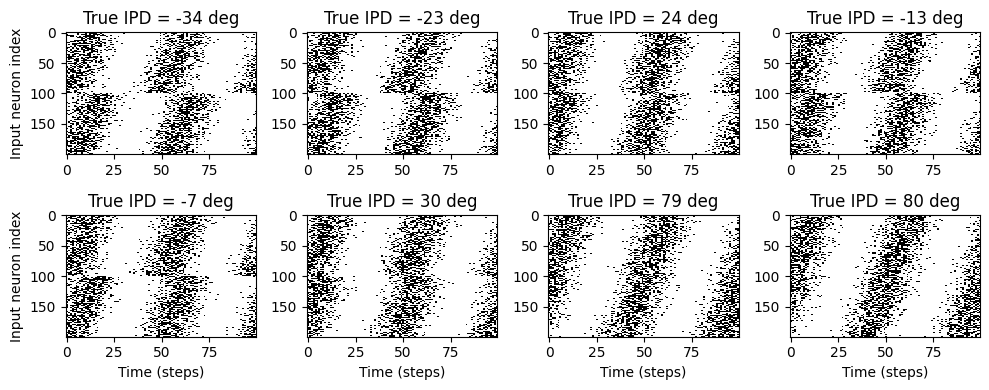

In [ ]:
# Plot for a few true IPDs the generated spike trains of the auditory nerve fibers to show how it looks.
# The first 100 lines are auditory nerve fiber responses of the righ ear and the others are from the left ear.
# You note that the IPDs was applied to the left ear's fibers.
ipd, spikes, theta = random_ipd_input_signal(8)
plt.figure(figsize=(10, 4), dpi=100)
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(spikes[i, :, :].T, aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)
    plt.title(f'True IPD = {int(ipd[i]*180/np.pi)} deg')
    if i>=4:
        plt.xlabel('Time (steps)')
    if i%4==0:
        plt.ylabel('Input neuron index')
plt.tight_layout()

#### Inspect the generated data







The objective of this section is to gain a deeper understanding of how the data generation function operates and to closely examine the generated output. This exploration will help us intuitively grasp what the dataset represents and how it encodes auditory nerve responses to stimuli with varying **Interaural Phase Differences (IPDs).** Let's generate a set of data and plot them with more details:

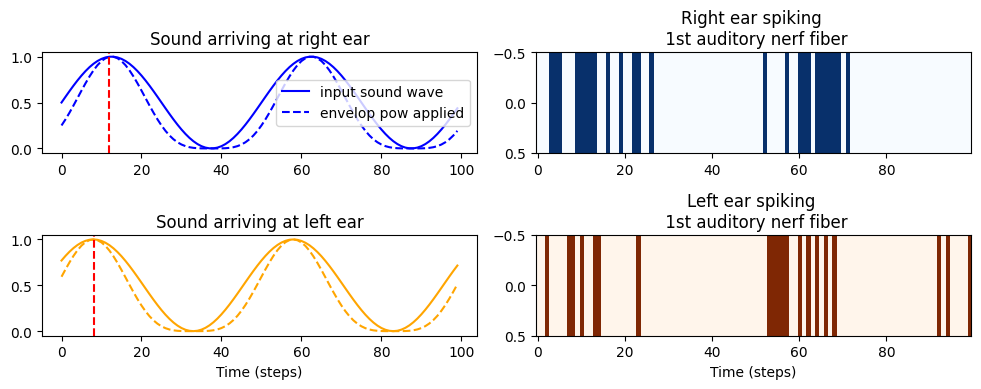

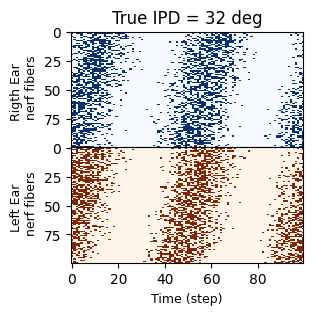

In [ ]:
# To experiment with different envelope powers, modify the value in the function arguments.
# This approach avoids altering the globally defined `envelope_power` variable, ensuring consistency elsewhere in the code.
ipd, spikes, theta = random_ipd_input_signal(1, envelope_power=10)

i = 0  # Select the index of the IPD sample to analyze or visualize.ipd, spikes, theta = random_ipd_input_signal(1, envelope_power=10)

# Plot for each ear the input signal and the spike transformed signal in the first auditory nerf fiber of each ear
fig, ax = plt.subplots(2,2, figsize=(10, 4))
ax[0,0].set_title('Sound arriving at right ear')
ax[0,0].plot(0.5*(1+np.sin(theta[i,:,0])),color='blue', label='input sound wave')
ax[0,0].plot((0.5*(1+np.sin(theta[i,:,0])))**envelope_power,color='blue', linestyle='--', label='envelop pow applied')

index = np.argmin(np.abs(theta[i, :, 0] - (np.pi/2 + (2 * np.pi if theta[0, 0, 0] > np.pi/2 else 0))))
ax[0,0].axvline(x=index, color='r', linestyle='--') # Plot a vertical dashed line at this position
ax[0,0].legend()
ax[0,1].set_title('Right ear spiking \n 1st auditory nerf fiber')
ax[0,1].imshow(spikes[i, :, [0]].T, aspect='auto', interpolation='nearest', cmap='Blues')

ax[1,0].set_title('Sound arriving at left ear')
ax[1,0].plot(0.5*(1+np.sin(theta[i,:,100])),color='orange')
ax[1,0].plot((0.5*(1+np.sin(theta[i,:,100])))**envelope_power,color='orange',linestyle='--')

index = np.argmin(np.abs(theta[i, :, 100] - (np.pi/2 + (2 * np.pi if theta[0, 0, 100] > np.pi/2 else 0))))
ax[1,0].axvline(x=index, color='r', linestyle='--') # Plot a vertical dashed line at this position
ax[1,0].set_xlabel('Time (steps)')

ax[1,1].set_title('Left ear spiking \n 1st auditory nerf fiber')
ax[1,1].imshow(spikes[i, :, [100]].T, aspect='auto', interpolation='nearest', cmap='Oranges')
ax[1,1].set_xlabel('Time (steps)')

plt.tight_layout()



# Plot the spike transformed signal in all auditory nerf fibers, where each
# fiber adds an increasing delay Create the figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(3, 3))  # Two vertically stacked subplots

# Plot the upper half with blue colormap
ax1.set_title(f'True IPD = {int(ipd[i]*180/np.pi)} deg')
ax1.imshow(spikes[i, :, : anf_per_ear].T, aspect='auto', interpolation='nearest', cmap='Blues')
# Customize the appearance of the axis
ax1.set_ylabel("Rigth Ear \n nerf fibers", fontsize=9)  # Add label with a custom font size
ax1.tick_params(left=True, labelleft=True, bottom=False, labelbottom=False)  # Hide ticks but keep the label

# Plot the lower half with orange colormap
ax2.imshow(spikes[i, :, anf_per_ear:].T, aspect='auto', interpolation='nearest', cmap='Oranges')
ax2.set_ylabel("Left Ear \n nerf fibers", fontsize=9)  # Add label with a custom font size
ax2.tick_params(left=True, labelleft=True, bottom=True, labelbottom=True)  # Hide ticks but keep the label
ax2.set_xlabel("Time (step)", fontsize=9)  # Add label with a custom font size

# Adjust spacing to remove gaps between the plots
plt.subplots_adjust(hspace=0)

# Show the final result
plt.show()




##### **Key Observations:**

1. **Examining the Input Signal and Spike Train for a Single IPD:**
   - For a specific IPD, the input signal and its corresponding transformed spike train are plotted for the **first auditory nerve fiber of each ear**.
   - The **IPD** is applied to the left ear, causing a **phase shift** in its spike pattern relative to the right ear. This phase shift is critical for encoding spatial auditory information.

2. **Effect of `envelope_power`:**
   - Values of `envelope_power` greater than 1 introduce a **nonlinearity** to the signal, sharpening the envelope of the stimulus.
   - Sharper envelopes make the patterns more distinguishable, which can potentially help the neural network in learning to classify the IPDs more accurately.

3. **Spike Train Visualization for All Nerve Fibers:**
   - For a selected IPD value, the spike trains of all auditory nerve fibers are displayed:
     - The **first 100 rows (blue)** correspond to the right ear.
     - The **next 100 rows (orange)** correspond to the left ear.
   - **Phase Delays by Fiber Index**:
     - Nerve fibers with **higher indices** introduce **stronger phase delays**. This is modeled to reflect how real auditory nerve fibers respond differently based on their spatial distribution.
   - The **IPD application** to the left ear introduces a phase shift in its fibers relative to the right ear's fibers.

---
---
## Classification Approach

---
---






  The objective is to take the input spike data and infer the **Interaural Phase Difference (IPD)** using a neural network. To achieve this, we will:

  1. **Discretize the IPD range** into categories (segments).  
  2. **Train a neural network** to predict the category (segment) to which the input belongs.

  This classification approach simplifies the continuous IPD estimation problem by transforming it into a discrete class prediction task, making it computationally efficient and suitable for neural network-based learning.

  ---

  ### **Step 1. Discretizing the IPD Range**

  To prepare the data for classification, we divide the continuous IPD range $[- \pi/2, \pi/2]$ into $N_c$ equal-width segments. Each segment corresponds to a class, effectively mapping the continuous IPD into discrete categories.

  For a given angle $\phi$, the **class index** is calculated as:
  $$
  \text{Class Index} = \text{floor} \left( \frac{(\phi + \pi/2) \cdot N_c}{\pi} \right)
  $$

  #### **Here:**
  - $N_c$: Number of classes (or segments).  
  - $\phi$: Continuous IPD value to be discretized.  

  ---

  ### **Step 2. Neural Network Prediction**

  The neural network takes the **input spike data** and outputs a **probability vector** $\mathbf{y}$ of length $N_c$, where:  
  - Each element $y_i$ represents the network’s confidence that the input belongs to class $i$.  
  - The predicted class is the index of the maximum value in $\mathbf{y}$:  
  $$
  i_{\text{est}} = \text{argmax}_i \, y_i
  $$

  ---

  ### **Step 3. Reconstructing the IPD**

  To reconstruct the continuous IPD value $\phi$ from the predicted class index $i_{\text{est}}$, we compute the midpoint of the corresponding segment:  
  $$
  \phi_i = a + \left(i + \frac{1}{2}\right) \frac{(b - a)}{N_c}
  $$

  #### **Here:**
  - $a = -\pi/2$ and $b = \pi/2$ are the bounds of the IPD range.  

  ---

In [ ]:
# classes at 15 degree increments
num_classes = 180//15
print(f'Number of classes = {num_classes}')

def discretise(ipds):
    """
      Discretize Interaural Phase Differences (IPDs) to generate class labels.

      The function maps IPDs, which are continuous values in the range (-pi/2, pi/2),
      to discrete classes in the range [0, num_classes-1]. The resulting discrete values
      are suitable for classification tasks.

        Parameters
        ----------
        ipds : Tensor
            A tensor containing continuous IPD values. The values should be in the range (-pi/2, pi/2).

        Returns
        -------
        Tensor
            A tensor containing the classification of IPD values, in the range [0, num_classes-1].

        Notes
        -----
        - Assumes the input `ipds` is a PyTorch tensor.
        - `num_classes` should be defined in the surrounding scope.
        - The output tensor will have the same shape as the input `ipds`.

        Examples
        --------
        >>> ipds = torch.tensor([-np.pi/2, 0, np.pi/2])
        >>> ipd_indices = discretise(ipds)
    """
    return ((ipds+np.pi/2)*num_classes/np.pi).long() # assumes input is tensor

def continuise(ipd_indices): # convert indices back to IPD midpoints
    """
      This function maps IPD indices, which are discrete values in the range [0, num_classes-1],
      back to continuous IPD values. The resulting continuous values are suitable for
      representing the midpoints of the original IPD ranges in the continuous domain.

        Parameters
        ----------
        ipd_indices : array-like
            An array or tensor of IPD indices, which are discrete values obtained from
            discretizing continuous IPDs into `num_classes` bins by the function discretise(ipds).

        Returns
        -------
        array-like
            An array or tensor of continuous IPD midpoints, corresponding to the provided
            `ipd_indices`. The midpoints are computed based on the assumed discretization
            strategy, and are in the range (-pi/2, pi/2).

        Notes
        -----
        - `num_classes` should be defined in the surrounding scope and should be the same
          value that was used for discretization.
        - The input `ipd_indices` and the output will have the same shape.
        - The output type (e.g., NumPy array, PyTorch tensor) will match the input type.
    """
    return (ipd_indices+0.5)/num_classes*np.pi-np.pi/2

Number of classes = 12


### Let's test these two functions and display the found classes and the midpoints in a table


In [ ]:
import pandas as pd

ipds, spikes, _ = random_ipd_input_signal(num_samples=10)
ipd_indices = discretise(ipds)
classes_ipd_midpoints = continuise(ipd_indices)

data = {'ipds':ipds,
        'classes':ipd_indices,
        'classes_ipd_midpoints':classes_ipd_midpoints}
data_df = pd.DataFrame(data)
data_df

,ipds,classes,classes_ipd_midpoints
0,-0.115562,5,-0.130900
1,-0.737785,3,-0.654499
2,0.239584,6,0.130900
3,-1.261090,1,-1.178097
4,-1.454595,0,-1.439897
5,0.980046,9,0.916298
6,-0.171898,5,-0.130900
7,-0.274938,4,-0.392699
8,-0.512133,4,-0.392699
9,0.220898,6,0.130900


# The neural network

We will now set up two types of neural network models and train them to solve the sound localization classification task. These models will allow us to explore different computational approaches to neural processing:

1. **Artificial Neural Network (ANN)**:  
   - This network uses continuously operating neurons. Each neuron functions as a *leaky integrator*, meaning its membrane potential integrates incoming inputs over time but naturally decays back to its resting potential with a specific time constant.  
   - Unlike biological neurons, ANN neurons do not produce action potentials (spikes); instead, their activity remains continuous, making them mathematically simpler to model.  
   - These neurons operate under differentiable dynamics, enabling us to train the network using standard backpropagation techniques, as in traditional machine learning models.

2. **Spiking Neural Network (SNN)**:  
   - In this model, we incorporate neurons that emit *spikes* when their membrane potential crosses a fixed threshold. After firing a spike, the membrane potential is reset to its resting state, mimicking the behavior of biological neurons.  
   - This spiking mechanism introduces a time-sensitive aspect to the computation, enabling the network to potentially detect coincident inputs more effectively than an ANN.  

By comparing the performance of these two models, we will explore whether the spiking mechanism in the SNN offers advantages for solving tasks that require precise timing, such as sound localization.  

Before diving into the implementation, let’s start with some general background to build intuition and motivation for this approach.

## Background:

In this section, we will introduce the fundamentals of artificial neural networks (ANNs) and how they are trained. Neural networks are a class of machine learning models that mimic the structure and function of biological neural systems, using interconnected layers of computational units (neurons) to process data. These models are particularly effective for tasks involving complex, non-linear patterns, such as sound localization.

### ### **Slide 1: Anatomy of a Single Neuron in an ANN**






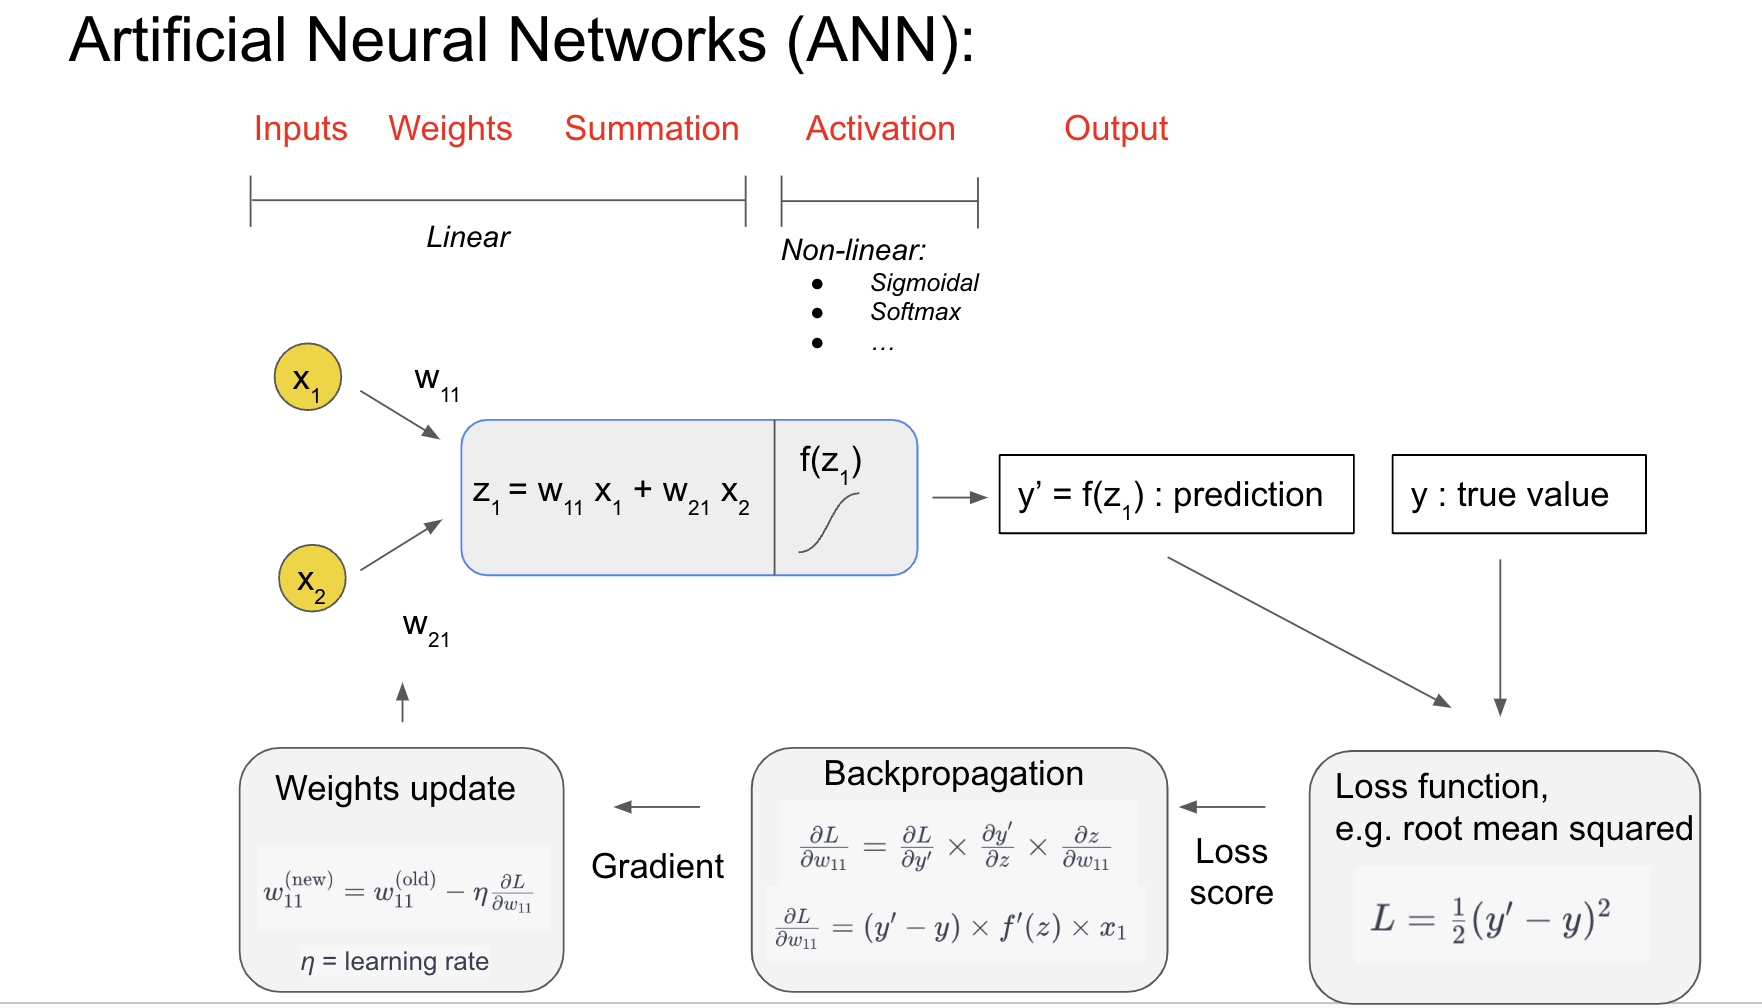


1. **Inputs and Weights**:  
   - Each neuron receives inputs ($x_1, x_2, \ldots$) representing features of the data, such as sound frequency or amplitude in our sound localization task.
   - Each input is assigned a weight ($w_{11}, w_{21}, \ldots$), which determines its contribution to the neuron’s output. These weights are learned during training.

2. **Summation**:  
   - The neuron calculates a weighted sum of its inputs:  
     $$
     z = \sum w_i x_i
     $$
     This summation is a linear operation, forming the basis for the neuron’s computation.

3. **Activation Function**:  
   - To capture complex, non-linear relationships, the weighted sum is passed through an activation function ($f(z)$), such as Sigmoid or ReLU (Rectified Linear Unit).  
   - The activation function introduces non-linearity, allowing the network to model intricate patterns in the data.

4. **Prediction**:  
   - The output of the neuron, $y'$, represents the prediction or decision of the network for this step. It will be compared to the actual value ($y$) during training.

5. **Loss Function**:  
   - To measure how far off the prediction ($y'$) is from the true value ($y$), a loss function is used. For example, the Mean Squared Error (MSE) calculates the average squared difference between $y$ and $y'$:  
     $$
     L = \frac{1}{2}(y' - y)^2
     $$

6. **Training the ANN: Backpropagation and Weight Updates**:  
   - Network training aims to minimize the error between the prediction and the true value. This is achieved by minimizing the loss function using gradient descent.
   - During training, the network adjusts the weights by calculating the gradient of the loss function with respect to each weight ($\partial L / \partial w$).  
   - During training, the network updates its weights to reduce the error between its predictions and the true values. This is done by calculating the gradient of the loss function with respect to each weight ($\partial L / \partial w$). The gradient tells us the direction and magnitude of the change needed in the weight to minimize the loss function.

    To control how much the weights are adjusted in each step, a **learning rate** ($\eta$) is introduced. The learning rate is a small positive value that determines the step size for weight updates. Combining the gradient and the learning rate, the weight update rule can be written as:

    $$
    w_{\text{new}} = w_{\text{old}} - \eta \frac{\partial L}{\partial w}
    $$

    Here:
    - $w_{\text{new}}$: The updated weight.
    - $w_{\text{old}}$: The current weight before the update.
    - $\eta$: The learning rate.
    - $\frac{\partial L}{\partial w}$: The gradient of the loss function with respect to the weight.

    The learning rate plays a crucial role in training:
    - If $\eta$ is too large, the updates may overshoot the optimal weights, causing the training process to diverge.
    - If $\eta$ is too small, the updates will be very slow, and the training may take a long time to converge.

    By iteratively adjusting the weights using this rule, the network gradually reduces the loss function, improving its predictions over time. This process is known as **gradient descent**.






### **Slide 2: Multi-Layer Networks**


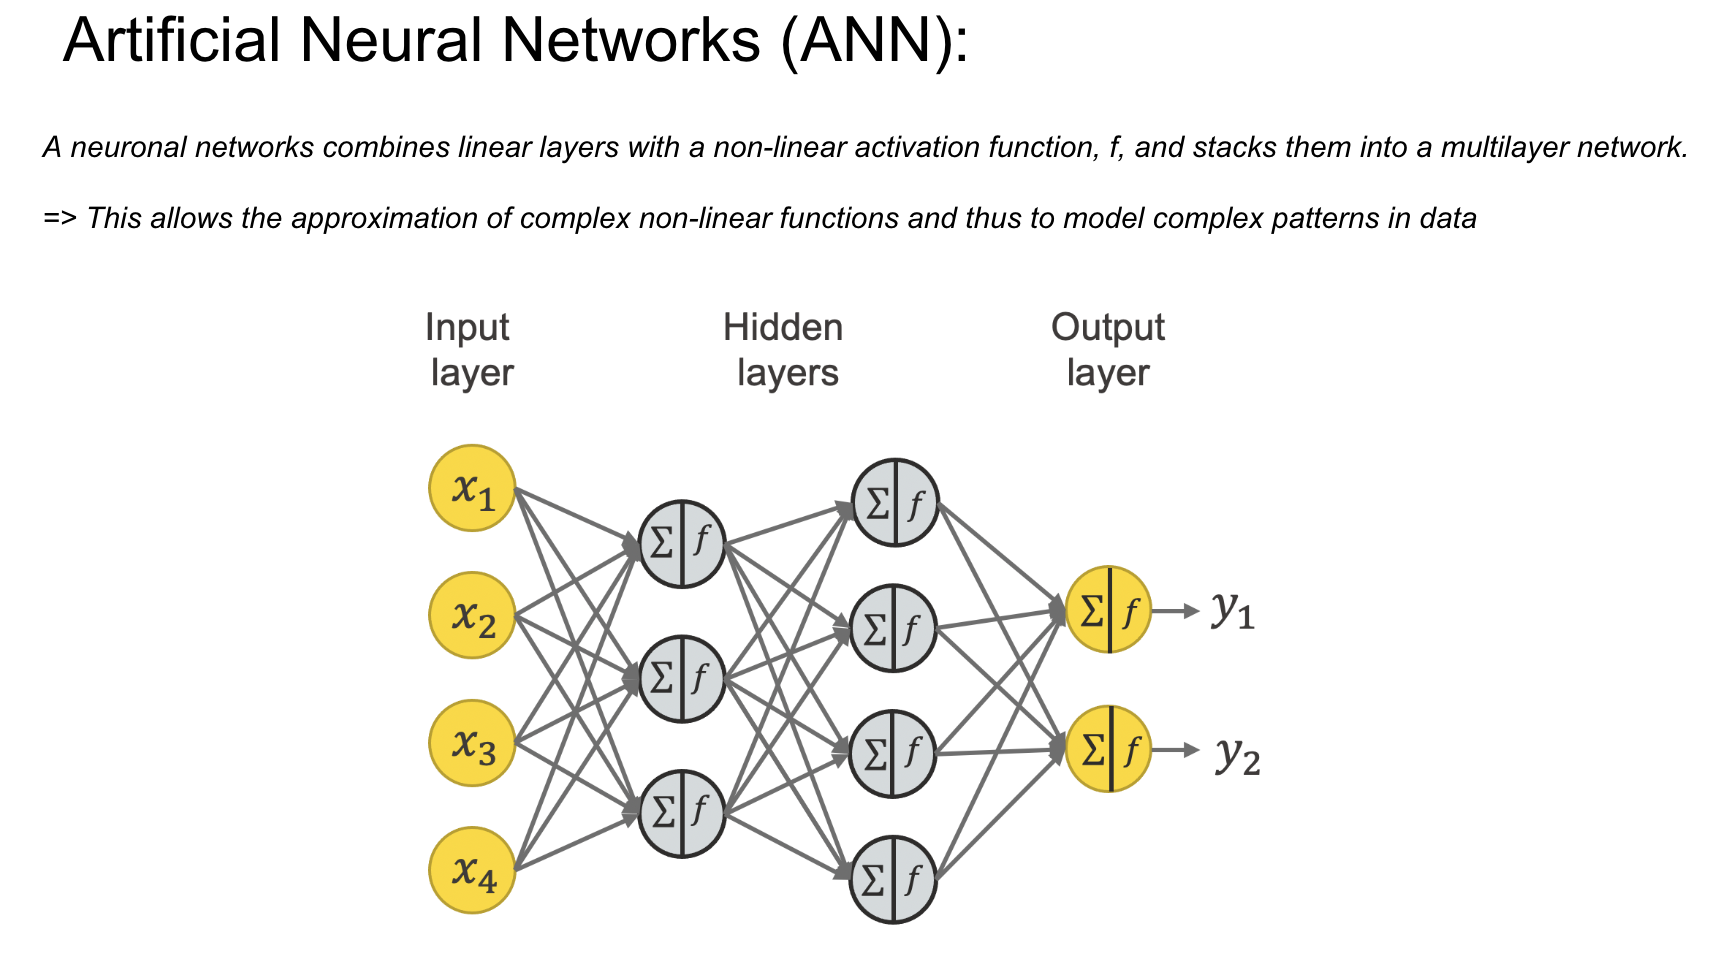


This slide expands the single-neuron concept into a multi-layer network, introducing the idea of layers:

1. **Input Layer**:  
   - The input layer receives raw data ($x_1, x_2, x_3, x_4$), which are features relevant to the task at hand.

2. **Hidden Layers**:  
   - Hidden layers are composed of multiple interconnected neurons. Each layer processes the data and extracts features at increasingly abstract levels.  
   - The combination of weighted summation, activation functions, and interconnected neurons enables the network to approximate complex functions.

3. **Output Layer**:  
   - The output layer produces the final predictions ($y_1, y_2, \ldots$) based on the processed information from the hidden layers.  
   - The number of neurons in the output layer corresponds to the number of classes or outputs in the task (e.g., e.g., in our case, the classes represent the segments of the interaural phase difference, which are related to the angles of sound source localization).

4. **Non-Linearity and Power of Deep Networks**:  
   - By stacking multiple layers, the network gains the capacity to model highly non-linear and intricate relationships in data, which are essential for tasks like sound localization.


## Implementation 1: Membrane only (no spiking) neural network (ANN)

Before we get to spiking, we're going to warm up with a non-spiking network that shows some of the features of the full model but without any coincidence detection, it can't do the task. We basically create a neuron model that has everything except spiking, so the membrane potential dynamics are there and it takes spikes as input. The neuron model we'll use is just the LIF model we've already seen. We'll use a time constant $\tau$ of 20 ms, and we pre-calculate a constant $\alpha=\exp(-dt/\tau)$ so that updating the membrane potential $v$ is just multiplying by $\alpha$ (as we saw in the first notebook). We store the input spikes in a vector $s$ of 0s and 1s for each time step, and multiply by the weight matrix $W$ to get the input, i.e. $v\leftarrow \alpha v+Ws$.

We initialise the weight matrix $W$ uniformly with bounds proportionate to the inverse square root of the number of inputs (fairly standard, and works here).

The output of this will be a vector of $N_c$ (``num_classes``) membrane potential traces. We sum these traces over time and use this as the output vector (the largest one will be our prediction of the class and therefore the IPD).

![Membrane only architecture](https://github.com/neural-reckoning/cosyne-tutorial-2022/blob/main/arch-membrane.png?raw=1)

### Functions to construct the model and calculte output form input samples

1. **The `init_weight_matrix()` function**:  
   - This function initializes the weight matrix, which defines the connections between neurons in the network. By specifying all the synaptic connections, it sets up the neural network's architecture.  
   - The implementation is done using PyTorch, where vectors and matrices are represented as **tensors**. Tensors are more than simple arrays; they also store information about gradients, enabling efficient computations during backpropagation and optimization.  
    - ```
    W = nn.Parameter(torch.empty((input_size, num_classes), device=device, dtype=dtype, requires_grad=True))
    ```

    - Each element of W represents a weight associated with a specific connection between an input unit and an output neuron.
    - The element in the i-th row and j-th column corresponds to the weight connecting the i-th input to the j-th output neuron.
   - If you need to visualize the weight matrix or any output vector, remember to **detach** the tensor first. Detaching removes the gradient-tracking capabilities, converting the tensor into a plain array suitable for visualization or further non-gradient-based processing:  
   


  ```
          numpy_array = tensor_A.detach().numpy()
  ```



2. **The `membrane_only(input_spikes, W, tau=20*ms)` function**:  
   - This function simulates the neural network's activity by calculating its output for a given input configuration. It models how the network processes input spikes using the defined weight matrix (`W`) and a membrane time constant (`tau`), capturing the temporal dynamics of the neurons.

In [ ]:
# Weights and uniform weight initialisation
def init_weight_matrix():
    """
      Initialize a weight matrix for a neural network layer using uniform distribution.

      The function initializes a weight matrix, `W`, with dimensions `(input_size, num_classes)`.
      The matrix is initialized using a uniform distribution over `[-bound, bound]`, where
      `bound` is computed as the inverse of the square root of the fan-in (number of input units).

      This initialization method helps in achieving faster convergence during training by
      setting initial weights in a range that's inversely proportional to the square root
      of the number of input units.

        Returns
        -------
        W = nn.Parameter
            A tensor representing the initialized weight matrix. The tensor has the attribute
            `requires_grad=True`, indicating that gradients will be computed with respect to this tensor
            during the backward pass.

          Notes
          -----
          - `input_size` and `num_classes` should be defined in the surrounding scope.
          - The tensor is moved to the device specified by the `device` variable and has the data type
            specified by the `dtype` variable. Both `device` and `dtype` should be defined in the surrounding scope.
          - The `requires_grad=True` argument in `nn.Parameter` ensures that gradients are computed for
            this tensor, enabling learning of its values during optimization.

          Examples
          --------
          >>> W = init_weight_matrix()
          >>> print(W.shape)
          (input_size, num_classes)
    """
    # Note that the requires_grad=True argument tells PyTorch that we'll be computing gradients with
    # respect to the values in this tensor and thereby learning those values. If you want PyTorch to
    # learn some gradients, make sure it has this on.
    W = nn.Parameter(torch.empty((input_size, num_classes), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W) # corresponds to the number of input units
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(W, -bound, bound)
    return W

# Run the simulation
def membrane_only(input_spikes, W, tau=20*ms):
    """
      Run a simulation of a membrane potential dynamic in response to input spikes.

      This function simulates the evolution of membrane potential `v` across time, given a batch of
      input spike trains `input_spikes` and synaptic weight matrix `W`. The membrane potential is
      updated at each time step based on the previous potential, the input spikes, and the synaptic weights,
      with an exponential decay parameterized by `tau`.

        Parameters
        ----------
        input_spikes : Tensor
            A 3D tensor representing a batch of input spike trains.
            Shape: (batch_size, duration_steps, input_size)
        W : Tensor
            A 2D tensor representing the synaptic weight matrix.
            Shape: (input_size, num_classes)
        tau : float, optional
            The time constant for the exponential decay of the membrane potential, in seconds.
            Default is 20 ms.

        Returns
        -------
        v_rec : Tensor
            A 3D tensor containing the recorded membrane potentials for each batch, time step, and class.
            Shape: (batch_size, duration_steps, num_classes)

        Notes
        -----
        - `batch_size`, `num_classes`, `duration_steps`, `device`, and `dtype` should be defined in the
          surrounding scope or passed as arguments.
        - `input_spikes` should be a binary tensor, where `input_spikes[b, t, i]` is 1 if there is a spike
          from input neuron `i` at time `t` in batch `b`, and 0 otherwise.
        - `W` should contain synaptic weights such that `W[i, j]` is the weight from input neuron `i` to
          output neuron `j`.

        Examples
        --------
        >>> input_spikes = torch.tensor([[[1, 0], [0, 1], [1, 1]]], dtype=dtype, device=device)
        >>> W = torch.tensor([[0.5, -0.5], [-0.5, 0.5]], dtype=dtype, device=device)
        >>> v_rec = membrane_only(input_spikes, W)
        >>> print(v_rec.shape)
        (1, 3, 2)
    """
    # Input has shape (batch_size, duration_steps, input_size)
    v = torch.zeros((batch_size, num_classes), device=device, dtype=dtype)
    # v_rec will store the membrane in each time step
    v_rec = [v]
    # Batch matrix multiplication all time steps
    # Equivalent to matrix multiply input_spikes[b, :, :] x W for all b, but faster
    h = torch.einsum("abc,cd->abd", (input_spikes, W)) # Note h corresponds to z in Background Slide 1
    # precalculate multiplication factor
    alpha = np.exp(-dt/tau)
    # Update membrane and spikes one time step at a time
    for t in range(duration_steps - 1):
        v = alpha*v + h[:, t, :] # (batch_size, time step, number of output neurons).  The batch size indicates how many input samples are processed in parallel
        v_rec.append(v)
    # return the recorded membrane potentials stacked into a single tensor
    v_rec = torch.stack(v_rec, dim=1)  # (batch_size, duration_steps, num_classes)
    return v_rec

### Let's visualize the initialization of the weigth matrix


Text(0.5, 1.0, 'Distribution of initialized weights')

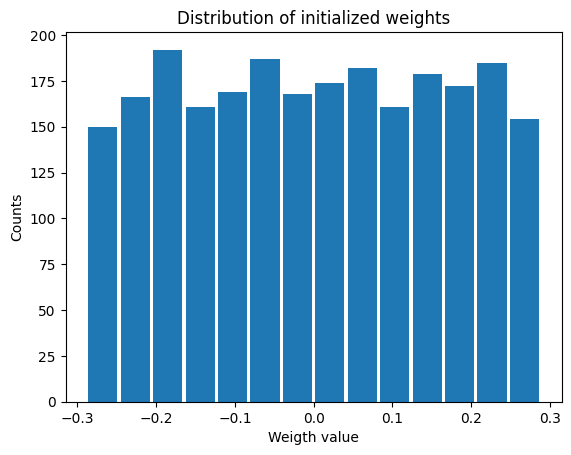

In [ ]:
W=init_weight_matrix();
plt.figure
plt.hist(W.detach().numpy().ravel(), bins='auto',rwidth=0.9);  # detach the tensor from the gradient calculation -> transform it to a numpy array -> unravel the 2D array into a 1D one
plt.xlabel('Weigth value')
plt.ylabel('Counts')
plt.title('Distribution of initialized weights')

### Training

We train this by dividing the input data into batches and computing gradients across batches. In this notebook, batch and data size is small so that it can be run on a laptop in a couple of minutes, but normally you'd use larger batches and more data. Let's start with the data.



### Training follows the following algorithm:

1. Shuffle the training data and divide them into batches. This is done by the function: **data_generator(discretise(ipds), spikes)**. Note that this function outputs with every execution a new set of batches after shuffling the input data.
2. Calculate the network output for every input value in the batch. Compute the loss for each point and then find the average loss across the entire batch. Here we use as loss function the Negative Log likelihood Loss function: **loss_fn = nn.NLLLoss()**. Note: This loss function computes the average loss accross the input batch by default.
3. To update the weights, calculate the gradient of the average loss function with respect to the model parameters, which is equivalent to computing the average of the individual gradients from the points in the batch. This is done by the function: **loss.backward()**
4. Update the weights according to the formular: w_new = w_old - lr * avg_i(dL_i/dw), where lr represents the learning rate. This is done by the function: **optimizer.step()**
5. Once all batches have been processed, begin a new epoch of the training process. Shuffle the data, define a new set of batches, and repeat the training.

In [ ]:
# Parameters for training. These aren't optimal, but instead designed
# to give a reasonable result in a small amount of time for the tutorial!
if my_computer_is_slow:
    batch_size = 64
    n_training_batches = 64
else:
    batch_size = 128
    n_training_batches = 128
n_testing_batches = 32
num_samples = batch_size*n_training_batches

# NOTE 1:A batch is a subset of the training dataset used for a single update of the model parameters.
# Rather than updating model parameters after processing each individual data point (stochastic gradient descent),
# batches allow the network to update parameters after processing a group of data points.
# This approach is called mini-batch gradient descent and is more computationally efficient than stochastic gradient descent.
# The size of a batch, known as the batch size, is an important hyperparameter and can affect
# the model's training dynamics and performance.

# NOTE2 : Small batch sizes improve generalization through noisier gradients and
# require less memory, making them ideal for limited resources, but they may
# lead to slower computation and less stable convergence due to noisier gradient
# updates. Conversely, large batch sizes enhance computational efficiency and stability
# of gradient estimates due to better GPU utilization, but they demand more memory and
# might result in poorer generalization due to the risk of converging to sharp minima
# that don't generalize well on unseen data.




# Generator function iterates over the data in batches
# We randomly permute the order of the data to improve learning
def data_generator(ipds, spikes):
    """
    Generate batches of data, iterating over IPDs and spikes in a randomized order.

    This generator function yields shuffled batches of interaural phase differences (IPDs) and spikes,
    facilitating mini-batch gradient descent training of a model. The order of the data is randomized
    to improve learning, mitigating the risk of the model memorizing the order of the training data
    (overfitting) and helping the model generalize better to unseen data.

      Parameters
      ----------
      ipds : Tensor
          A 1D tensor of IPD values.
          Shape: (n_samples, )
      spikes : Tensor
          A 3D tensor representing a batch of input spike trains.
          Shape: (n_samples, duration_steps, input_size)

      Yields
      ------
      spike_batch : Tensor
          A 3D tensor containing a batch of input spike trains.
          Shape: (batch_size, duration_steps, input_size)
      ipd_batch : Tensor
          A 1D tensor containing a batch of IPD values.
          Shape: (batch_size, )

      Notes
      -----
      - `batch_size` should be defined in the surrounding scope or passed as an argument.
      - Ensure that `ipds` and the first dimension of `spikes` have the same size.
      - The generator yields `spike_batch` and `ipd_batch` which are randomly shuffled batches of `spikes` and `ipds` respectively.
    """
    perm = torch.randperm(spikes.shape[0])
    spikes = spikes[perm, :, :]
    ipds = ipds[perm]
    n, _, _ = spikes.shape
    n_batch = n//batch_size
    for i in range(n_batch):
        spike_batch = spikes[i*batch_size:(i+1)*batch_size, :, :]  # spike_batch
        ipd_batch   = ipds[i*batch_size:(i+1)*batch_size]          # ipd_batch
        yield spike_batch, ipd_batch               # yield means that at each function call the function returns the next result of the loop interation

Now we run the training. We generate the training data, initialise the weight matrix, set the training parameters, and run for a few epochs, printing the training loss as we go. We use the all-powerful Adam optimiser, softmax and negative log likelihood loss.

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=5.96144
Epoch 2: loss=3.25891
Epoch 3: loss=2.98991
Epoch 4: loss=2.69476
Epoch 5: loss=2.53694
Epoch 6: loss=2.46820
Epoch 7: loss=2.36351
Epoch 8: loss=2.23314
Epoch 9: loss=2.05013
Epoch 10: loss=2.03256


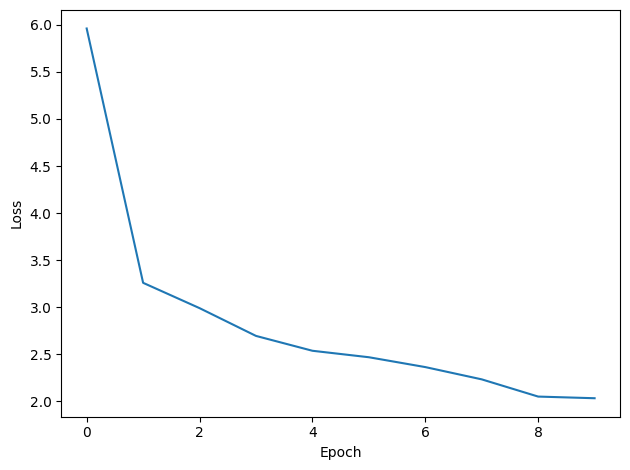

In [ ]:
# Training parameters
nb_epochs = 10 # is quick, it won't have converged.
# Note: An epoch is one complete pass through the entire training dataset.
# During an epoch, the neural network processes every example in the dataset once.
# Completing an epoch means that every data point has been used for calculating the loss and updating the model parameters.
# Multiple epochs are usually required for the network to converge to an optimal set of parameters.

lr = 0.01 # learning rate

# Generate the training data
ipds, spikes, _ = random_ipd_input_signal(num_samples) # num_samples = batch_size*n_training_batches

# Initialise a weight matrix
W = init_weight_matrix()

# Optimiser and loss function
optimizer = torch.optim.Adam([W], lr=lr)
log_softmax_fn = nn.LogSoftmax(dim=1)
loss_fn = nn.NLLLoss() # negative log likelihood loss. Note: This loss function computes the average loss accross the input batch by default.

print(f"Want loss for epoch 1 to be about {-np.log(1/num_classes):.2f}, multiply m by constant to get this")

loss_hist = []
plt.figure
for e in range(nb_epochs):
    local_loss = []
    for spike_batch, ipd_batch in data_generator(discretise(ipds), spikes):
        # Run network
        output = membrane_only(spike_batch, W) # our function to calculate the forward path from input to output
        #output = torch.abs(output)
        # Compute cross entropy loss
        m = torch.sum(output, 1)*0.01  # Sum the output over the time dimension. Note: We want loss for epoch 1 to be about -np.log(1/num_classes), multiply m by a constant to get this
        loss = loss_fn(log_softmax_fn(m), ipd_batch)
        local_loss.append(loss.item())

        # The softmax function transforms the output of a neural network's final layer into a probability
        # distribution over multiple classes in such a way that increasing the score of one class
        # decreases the probabilities of the other classes. It does this by exponentiating each logit
        # and then normalizing these values so that they sum to 1. This is important because it ensures that
        # the predicted values for each class sum up to 1.0. This probability distribution allows us to
        # interpret the network's output as the likelihood of each class being the correct class.
        # Training Objective: The training process aims to increase the probability of the correct class.
          # As the model updates its weights to increase the probability (and hence the log probability) of the
          # correct class, the softmax function inherently decreases the probabilities of the other classes due
          # to the normalization step.
          # Using it with the negative log likelihood loss encourages the model to increase the log probability
          # of the correct class.
        # Interpretability: The softmax function's output can be interpreted as class probabilities, which is
          # valuable not only for making predictions but also for understanding the model's confidence in those
          # predictions. This can be useful for post-processing or decision-making based on the network's output
          # probabilities.

        # Update gradients
        optimizer.zero_grad() # set previous gradients to zero
        loss.backward() # calculate the gradient of the loss with respect to all model parameters
        optimizer.step() # update the weights according to the calculated gradients : new_model_parameter=old_model_parameter−learning rate×gradient_with_respect_to_model_parameter

    loss_hist.append(np.mean(local_loss))
    print("Epoch %i: loss=%.5f"%(e+1, np.mean(local_loss)))

# Plot the loss function over time
plt.plot(loss_hist)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()

### FYI: Explaination of the used loss function

In the above training we used the folloz loss function that we minimized to train hte network:

```
  loss = loss_fn(log_softmax_fn(m), ipd_batch)
```

Let`s go step-by-step to see how this works:

- m:
This is the model’s output for a batch of data, often referred to as logits. Logits are raw scores produced by the model, which are not yet normalized into probabilities.
- log_softmax_fn(m):
Converts the logits into normalized log-probabilities using the log-softmax function.
  1.	Softmax is first applied to normalize the logits into probabilities:
  $$
  \text{Softmax}(x_i) = \frac{\exp(x_i)}{\sum_{j} \exp(x_j)}
  $$

  The probabilities of all output neurons sum up to 1.

  2.	The natural logarithm (log) is then applied to these probabilities to make them log-scaled:
  $$
  \text{LogSoftmax}(x_i) = \log(\text{Softmax}(x_i)) = x_i - \log\left(\sum_j \exp(x_j)\right)
  $$

- ipd_batch:
Contains the ground truth labels for the batch, which are indices representing the true class of each sample.

- nn.NLLLoss():
The Negative Log-Likelihood Loss function computes then negative log-probability of the true class for each sample:
$$
\text{Loss} = -\log(\text{Predicted Probability of True Class})
$$
This ensures the loss value decreases as the model predicts higher probabilities for the true class.

- Overall Loss:
The total loss is the mean (or sum, depending on configuration) of the individual sample losses across the batch.

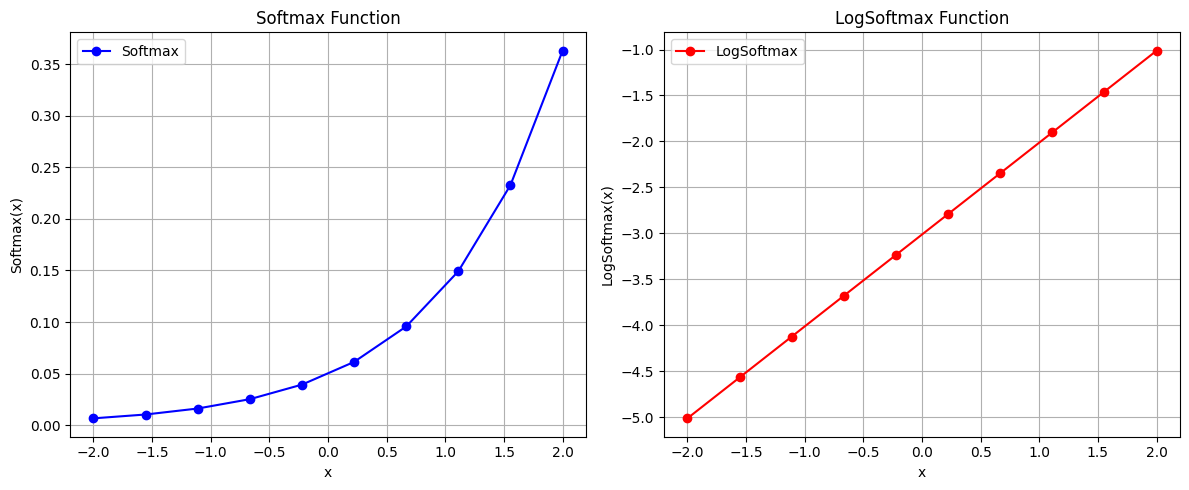

[0.2242605  0.60960324 0.16613626]
[1.49494696 0.49494696 1.79494696]


In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt

def softmax(x):
    e_x = np.exp(x - np.max(x))  # subtract max(x) for numerical stability
    return e_x / e_x.sum(axis=0)

def log_softmax(x):
    return np.log(softmax(x))

# Create a range of values
x = np.linspace(-2, 2, 10)

# Calculate softmax and log_softmax
y_softmax = softmax(x)
y_log_softmax = log_softmax(x)

# Create plots
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(x, y_softmax, label='Softmax', color='blue',marker='o')
plt.title('Softmax Function')
plt.xlabel('x')
plt.ylabel('Softmax(x)')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x, y_log_softmax, label='LogSoftmax', color='red',marker='o')
plt.title('LogSoftmax Function')
plt.xlabel('x')
plt.ylabel('LogSoftmax(x)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

x = [0.5, 1.5, 0.2]
print(softmax(x))
print(-np.log(softmax(x)))

The sum over the y_softmax is really one:

In [ ]:
# @title
sum(y_softmax)

1.0

### Analysis function definition

We define an analysis function that
- creates a test data set
- runs the model in a forward path to estimated the IPDs of this test set
- computes the training and test accuracy by comparing estimated to the true IPD values
- plots histograms and confusion matrices to understand the errors it's making.

In [ ]:
def analyse(ipds, spikes, label, run, plot_analysis=1):
    """
    Analyse the performance of a classifier on interaural phase difference (IPD) data.

    This function evaluates the accuracy and error of a classifier by comparing its
    output with true IPD values. It computes the mean and standard deviation of the
    classifier's accuracy and the absolute error in degrees. Additionally, it can
    generate histograms and a confusion matrix to visualize the results.

    Parameters:
    ipds (array): Array of true IPD values.
    spikes (array): Array of spike data corresponding to the IPDs.
    label (str): Label for the data, used in plot titles.
    run (callable): Function that runs the classifier on a batch of spike data.
    plot_analysis (bool, optional): If True, plot histograms and confusion matrix.

    Returns:
    tuple: Tuple containing mean and standard deviation of classifier accuracy,
           and mean and standard deviation of absolute error in degrees.
    """
    # Initialize lists to store batch-wise accuracies, true IPD values, and estimated IPD values.
    accs = []           # Stores accuracy for each batch
    ipd_true = []       # Stores the true IPD values
    ipd_estimated = []        # Stores the estimated IPD values

    # Initialize the confusion matrix for classifier evaluation
    confusion = np.zeros((num_classes, num_classes))

    # Iterate over batches of data (spikes and corresponding IPDs) generated randomly
    for spike_batch, ipd_batch in data_generator(ipds, spikes): #Generate batches of data, iterating over IPDs and spikes in a randomized order.
        # Discretize the IPD values in the batch by mapping them to their respective classes
        ipd_class_batch = discretise(ipd_batch)

        # Run the neural network classifier on the spike batch
        output = run(spike_batch)

        # Aggregate the network's output over the time dimension
        m = torch.sum(output, 1)

        # Use argmax to select the class with the highest score
        _, ipd_class_batch_estimated = torch.max(m, 1)
            # Note: We don’t use softmax(m) in the forward path but only torch.max(m) because:
            # - The task only requires class estimated, not probabilities.
            # - torch.max is sufficient to identify the estimated class index.
            # - Softmax would add unnecessary computational cost without affecting the correctness of the predictions.


        # Update the confusion matrix with true and estimated class values
        for i, j in zip(ipd_class_batch.detach().cpu().numpy(), ipd_class_batch_estimated.detach().cpu().numpy()):  # update the confusion matrix
            confusion[j, i] += 1
            # This code updates a confusion matrix by counting occurrences of true and predicted class pairs for a batch of data:
                # confusion[j, i] += 1:
                # - Increments the matrix cell at (j, i):
                #   - j: Predicted class.
                #   - i: True class.
                # - Tracks how often class i is predicted as class j.


        # Append the original IPD values to the true IPD list
        ipd_true.append(ipd_batch) # creates a list of arrays

        # Convert the argmax predictions back to continuous values and append to estimated IPDs
        ipd_estimated.append(continuise(ipd_class_batch_estimated.detach().cpu().numpy()))

        # Calculate batch accuracy by comparing predictions to labels
        tmp = np.mean((ipd_class_batch == ipd_class_batch_estimated).detach().cpu().numpy())  # compare to labels
        accs.append(tmp) # Append batch accuracy to the list

    # Flatten the lists of true and estimated IPDs into single arrays
    ipd_true = np.hstack(ipd_true) # connetecates the arrays in the list horizontally to create a single flattened array
    ipd_estimated = np.hstack(ipd_estimated)

    # Compute absolute errors in degrees between true and estimated IPDs
    abs_errors_deg = abs(ipd_true-ipd_estimated)*180/np.pi

    # Calculate mean and standard deviation of the classifier accuracy in percentage
    classifier_accuracy_mean = 100*np.mean(accs) # in percent
    classifier_accuracy_std = 100*np.std(accs) # in percent

    # Calculate mean and standard deviation of the absolute error in degrees
    absolute_error_mean = np.mean(abs_errors_deg) # in degree
    absolute_error_std = np.std(abs_errors_deg) # in degree

    # Print results for the classifier's accuracy and absolute error
    print(f"{label} classifier accuracy: {100*np.mean(accs):.1f}%")
    print(f"{label} absolute error: {np.mean(abs_errors_deg):.1f} deg \n")

    # If visualization is requested, plot the results
    if plot_analysis:
      plt.figure(figsize=(10, 4), dpi=100)

      # Plot histograms of true and estimated IPDs
      plt.subplot(121)
      plt.hist(ipd_true*180/np.pi, bins=num_classes, label='True')
      plt.hist(ipd_estimated*180/np.pi, bins=num_classes, label='Estimated')
      plt.xlabel("IPD")
      plt.yticks([])
      plt.legend(loc='best')
      plt.title(label)

      # Normalize the confusion matrix and plot it
      plt.subplot(122)
      confusion /= np.sum(confusion, axis=0)[np.newaxis, :]
      ConfusionMatrix = plt.imshow(confusion, interpolation='nearest', aspect='auto', origin='lower', extent=(-90, 90, -90, 90))
      plt.xlabel('True IPD')
      plt.ylabel('Estimated IPD')
      plt.title('Confusion matrix')
      plt.tight_layout()

      # Add a color bar with the label "Probability"
      cbar = plt.colorbar(ConfusionMatrix)  # Add color bar
      cbar.set_label('Probability')  # Set the label for the color bar
      plt.tight_layout()

    # Return the computed metrics
    return classifier_accuracy_mean, classifier_accuracy_std, absolute_error_mean, absolute_error_std


### Analysis of the network performance

By using our analysis function we run the model on a test data set that is different from the training data set and plot the analysis results.

Chance accuracy level: 8.3% 

Train classifier accuracy: 28.7%
Train absolute error: 19.5 deg 

Test classifier accuracy: 22.7%
Test absolute error: 21.6 deg 



(22.65625, 5.496580968543081, 21.590408188264117, 16.698834029736815)

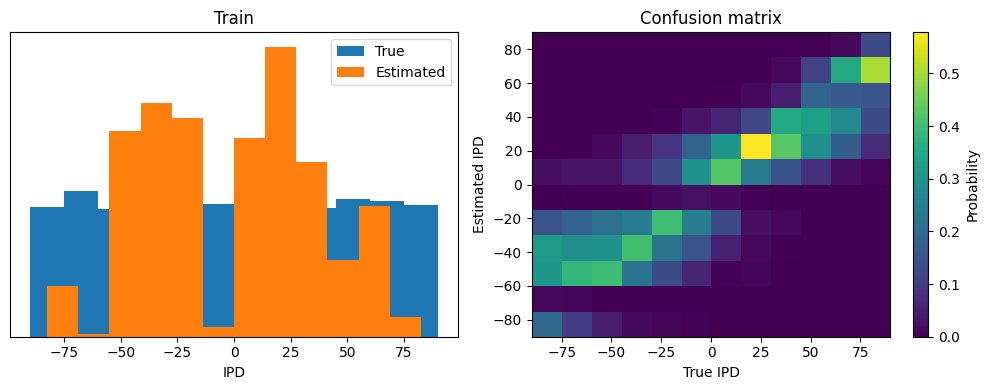

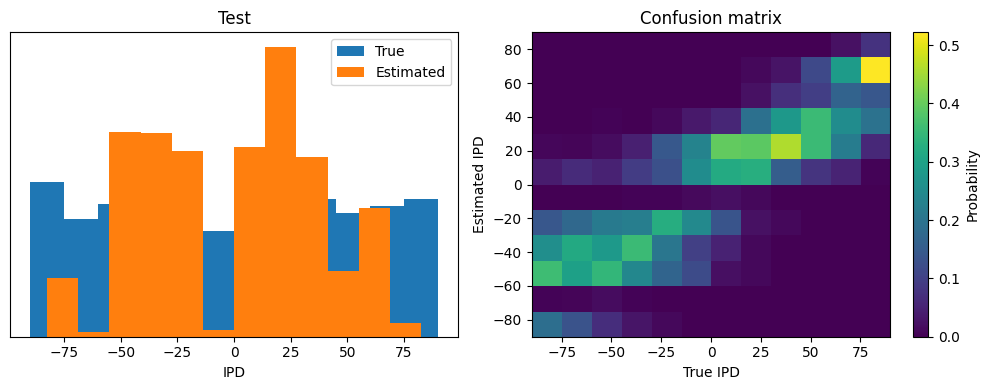

In [ ]:
print(f"Chance accuracy level: {100*1/num_classes:.1f}% \n")
run_func = lambda x: membrane_only(x, W)
analyse(ipds, spikes, 'Train', run=run_func)
ipds_test, spikes_test, _ = random_ipd_input_signal(batch_size*n_testing_batches)
analyse(ipds_test, spikes_test, 'Test', run=run_func)

### Let's look at the network parameters after the last epche

#### Dynamics of the output neurons

In [ ]:
# @title
# define the plot helper function
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import ScalarMappable

# We define here a helper function to control the line colors in a plot
def plot_lines_with_colorbar(x, ys, cmap_name='viridis', ax=None, colorbar_label=''):
    """
    This function defines the colormap over which the line plot function cycles
    and plots the corresponding colorbar next to the plot.

    Parameters:
    x (array-like): X-axis values.
    ys (list of arrays): List of Y-axis values for each line.
    cmap_name (str): Name of the colormap to use.
    ax (matplotlib axis, optional): Axis to plot on. Defaults to current axis.
    colorbar_label (str, optional): Label for the colorbar. Defaults to an empty string.

    Example usage:
    x = np.linspace(0, 10, 100)
    ys = [np.sin(x + i) for i in np.arange(0, 2, 0.5)]

    plt.figure(figsize=(8, 6))
    plot_lines_with_colorbar(x, ys, cmap_name='jet', colorbar_label='class index')
    plt.show()
    """
    if ax is None:
        ax = plt.gca()

    # Define a new color cycle
    num_lines = len(ys)
    new_color_cycle = plt.get_cmap(cmap_name)(np.linspace(0, 1, num_lines))

    # Set the color cycle for the axis
    ax.set_prop_cycle(color=new_color_cycle)

    # Plot multiple lines
    for y in ys:
        ax.plot(x, y)

    # Create a ScalarMappable object and plot the colorbar
    sm = ScalarMappable(cmap=cmap_name, norm=plt.Normalize(vmin=0, vmax=num_lines))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, ticks=np.linspace(0, num_lines, num_lines+1),
                        pad=0.01)
    # Add the label to the colorbar
    cbar.set_label(colorbar_label, rotation=270, labelpad=15)

nb_epochs = 10
output.shape = torch.Size([64, 100, 12]) => (epochs, time points, classes)


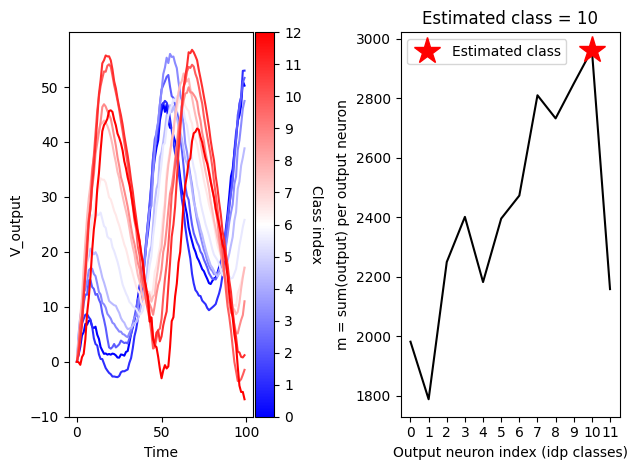

In [ ]:
print(f'nb_epochs = {nb_epochs}')
print(f'output.shape = {output.shape} => (epochs, time points, classes)')

plt.figure
#for i in range(num_classes):
#  plt.plot(output.detach().numpy()[63,:,i])
plt.subplot(1,2,1)
#ys = [torch.abs(output).detach().numpy()[63,:,i] for i in range(num_classes)]
ys = [output.detach().numpy()[63,:,i] for i in range(num_classes)]

plot_lines_with_colorbar(np.arange(duration_steps),ys, cmap_name='bwr',colorbar_label='Class index')
plt.xlabel('Time')
plt.ylabel('V_output')

plt.subplot(1,2,2)
# calculate output agregated over time for e.g. the sample number 63
m_selection = np.sum(output.detach().numpy()[63,:,:],0)
# determine the estimated class index
ipd_class_estimated = np.argmax(m_selection)

# plot agregated output neuron values
#plt.bar(np.arange(12),m,color='black')
plt.plot(np.arange(12),m_selection,color='black')
plt.plot(ipd_class_estimated, m_selection[ipd_class_estimated],'*r',markersize=20,label='Estimated class')


plt.title(f'Estimated class = {ipd_class_estimated}')

plt.xlabel('Output neuron index (idp classes)')
plt.ylabel('m = sum(output) per output neuron')
plt.xticks(ticks=np.arange(12))
plt.legend()
plt.tight_layout()

#### Weights distribution after training


Text(0.5, 1.0, 'after training')

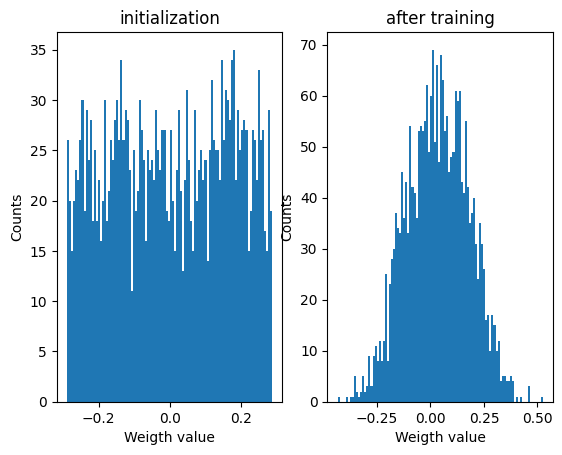

In [ ]:
plt.figure
plt.subplot(1,2,1)
plt.hist(init_weight_matrix().detach().numpy().ravel(),bins=100);
plt.xlabel('Weigth value')
plt.ylabel('Counts')
plt.title('initialization')

plt.subplot(1,2,2)
plt.hist(W.detach().numpy().ravel(),bins=100);
plt.xlabel('Weigth value')
plt.ylabel('Counts')
plt.title('after training')

#### Inferred ipds versus ipds

In [ ]:
m.shape
tmp = log_softmax_fn(m)
tmp.shape
output.shape
results = {'inferred ipds':np.argmax(m.detach().numpy(),1), 'true ipds':ipd_batch}
results_df = pd.DataFrame(results)
results_df

,inferred ipds,true ipds
0,3,3
1,3,2
2,6,5
3,3,5
4,7,7
...,...,...
59,7,7
60,3,3
61,3,0
62,10,10


This poor performance isn't surprising because this network is not actually doing any coincidence detection, just a weighted sum of input spikes.

## Implementation 2: Spiking neural network

Next we'll implement a version of the model with spikes to see how that changes performance. We'll just add a single hidden feed-forward layer of spiking neurons between the input and the output layers. This layer will be spiking, so we need to use the surrogate gradient descent approach.

![Full architecture](https://github.com/neural-reckoning/cosyne-tutorial-2022/blob/main/arch-full.png?raw=1)

### Surrogate gradient descent

First, this is the key part of surrogate gradient descent, a function where we override the computation of the gradient to replace it with a smoothed gradient. You can see that in the forward pass (method ``forward``) it returns the Heaviside function of the input (takes value 1 if the input is ``>0``) or value 0 otherwise. In the backwards pass, it returns the gradient of a sigmoid function.

In [ ]:
beta = 5

class SurrGradSpike(torch.autograd.Function):
    """
      This class allows for the approximation of gradients for non-differentiable spiking functions, enabling
      the backpropagation of errors in networks that incorporate spiking neurons. The forward method applies
      a thresholding logic, mimicking the firing of a neuron, while the backward method implements the surrogate
      gradient calculation.

      Methods
      -------
      @staticmethod
      forward(ctx, input):
          Computes the forward propagation step in the neural network. This method applies a specific logic to
          mimic the all-or-none spiking nature of biological neurons. It generates a binary output corresponding
          to whether each neuron in the input tensor has fired or not.
          Parameters:
              ctx : torch.autograd.function._ContextMethodMixin
                  A context object for storing information necessary for the backward computation.
              input : torch.Tensor
                  A tensor containing the input data, typically the neuronal activations in form of the membrane potential,
                  for which the output firing response will be computed.
          Returns:
              torch.Tensor: A tensor with the same shape as input, filled with binary values indicating whether
              each neuron has fired (1.0) or not (0.0).

      @staticmethod
      backward(ctx, grad_output):
          Computes the backward propagation step in the neural network. This method calculates the surrogate
          gradients of the loss function with respect to the input activations. It is designed to work with
          the non-differentiable nature of spiking neurons by approximating the gradients.
          Parameters:
              ctx : torch.autograd.function._ContextMethodMixin
                  A context object that has the information stashed during the forward pass.
              grad_output : torch.Tensor
                  A tensor containing the gradient of the loss function with respect to the outputs of the forward method.
          Returns:
              torch.Tensor: A tensor containing the surrogate gradients of the loss function with respect to
              the input activations, which can be backpropagated through the rest of the network.
      """
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        # Original SPyTorch/SuperSpike gradient
        # This seems to be a typo or error? But it works well
        #grad = grad_output/(100*torch.abs(input)+1.0)**2
        # Sigmoid
        grad = grad_output*beta*torch.sigmoid(beta*input)*(1-torch.sigmoid(beta*input))
        return grad

spike_fn  = SurrGradSpike.apply   # allows the defined class to be used as a function.

### Updated model

The code for the updated model is very similar to the membrane only layer. First, for initialisation we now need two weight matrices, $W_1$ from the input to the hidden layer, and $W_2$ from the hidden layer to the output layer. Second, we run two passes of the loop that you saw above for the membrane only model.

The first pass computes the output spikes of the hidden layer. The second pass computes the output layer and is exactly the same as before except using the spikes from the hidden layer instead of the input layer.

For the first pass, we modify the function in two ways.

Firstly, we compute the spikes with the line ``s = spike_fn(v-1)``. In the forward pass this just computes the Heaviside function of $v-1$, i.e. returns 1 if $v>1$, otherwise 0, which is the spike threshold function for the LIF neuron. In the backwards pass, it returns a gradient of the smoothed version of the Heaviside function.

The other line we change is the membrane potential update line. Now, we multiply by $1-s$ where ($s=1$ if there was a spike in the previous time step, otherwise $s=0$), so that the membrane potential is reset to 0 after a spike (but in a differentiable way rather than just setting it to 0).

In [ ]:
num_hidden = 100

# Weights and uniform weight initialisation
def init_weight_matrices():
    # Input to hidden layer
    W1 = nn.Parameter(torch.empty((input_size, num_hidden), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W1)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(W1, -bound, bound)
    # Hidden layer to output
    W2 = nn.Parameter(torch.empty((num_hidden, num_classes), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W2)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(W2, -bound, bound)
    return W1, W2

# Run the simulation
def snn(input_spikes, W1, W2, tau=20*ms):
    # First layer: input to hidden
    v = torch.zeros((batch_size, num_hidden), device=device, dtype=dtype)
    s = torch.zeros((batch_size, num_hidden), device=device, dtype=dtype)
    s_rec = [s]
    h = torch.einsum("abc,cd->abd", (input_spikes, W1))
    alpha = np.exp(-dt/tau)
    for t in range(duration_steps - 1):
        new_v = (alpha*v + h[:, t, :])*(1-s) # multiply by 0 after a spike
        s = spike_fn(v-1) # threshold of 1
        v = new_v
        s_rec.append(s)
    s_rec = torch.stack(s_rec, dim=1)
    # Second layer: hidden to output
    v = torch.zeros((batch_size, num_classes), device=device, dtype=dtype)
    s = torch.zeros((batch_size, num_classes), device=device, dtype=dtype)
    v_rec = [v]
    h = torch.einsum("abc,cd->abd", (s_rec, W2))
    alpha = np.exp(-dt/tau)
    for t in range(duration_steps - 1):
        # v = alpha * v + torch.where(h[:, t, :] > 0, h[:, t, :], torch.zeros_like(h[:, t, :]))   # VB  allow only positive inputs to change the membrane pot.
        v = alpha*v + h[:, t, :]
        v_rec.append(v)
    v_rec = torch.stack(v_rec, dim=1)
    # Return recorded membrane potential of output
    return v_rec

### Training and analysing


#### Training
We train it as before, except that we modify the functions to take the two weight matrices into account.

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=3.17483
Epoch 2: loss=1.54502
Epoch 3: loss=1.22398
Epoch 4: loss=0.99698
Epoch 5: loss=0.87871
Epoch 6: loss=0.77592
Epoch 7: loss=0.71269
Epoch 8: loss=0.67917
Epoch 9: loss=0.62464
Epoch 10: loss=0.57160


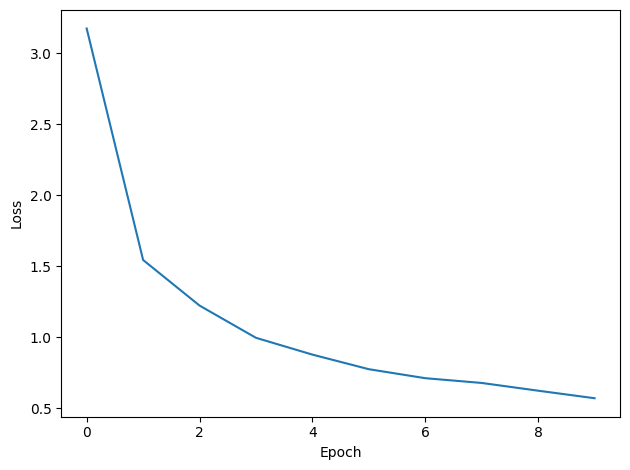

In [ ]:
# Training parameters
nb_epochs = 10 # quick, it won't have converged
lr = 0.01 # learning rate

# Generate the training data
ipds, spikes, _ = random_ipd_input_signal(num_samples)

# Initialise a weight matrices
W1, W2 = init_weight_matrices()

# Optimiser and loss function
optimizer = torch.optim.Adam([W1, W2], lr=lr)
log_softmax_fn = nn.LogSoftmax(dim=1)
loss_fn = nn.NLLLoss()

print(f"Want loss for epoch 1 to be about {-np.log(1/num_classes):.2f}, multiply m by constant to get this")

loss_hist = []
for e in range(nb_epochs):
    local_loss = []
    for spike_batch, ipd_batch in data_generator(discretise(ipds), spikes):
        # Run network
        output = snn(spike_batch, W1, W2)

        #output = torch.abs(output)

        # Compute cross entropy loss
        m = torch.mean(output, 1)  # Mean across time dimension
        loss = loss_fn(log_softmax_fn(m), ipd_batch)
        local_loss.append(loss.item())

        # The softmax function transforms the output of a neural network's final layer into a probability
        # distribution over multiple classes in such a way that increasing the score of one class
        # decreases the probabilities of the other classes. It does this by exponentiating each logit
        # and then normalizing these values so that they sum to 1. This is important because it ensures that
        # the predicted values for each class sum up to 1.0. This probability distribution allows us to
        # interpret the network's output as the likelihood of each class being the correct class.
        # Training Objective: The training process aims to increase the probability of the correct class.
          # As the model updates its weights to increase the probability (and hence the log probability) of the
          # correct class, the softmax function inherently decreases the probabilities of the other classes due
          # to the normalization step.
          # Using it with the negative log likelihood loss encourages the model to increase the log probability
          # of the correct class.
        # Interpretability: The softmax function's output can be interpreted as class probabilities, which is
          # valuable not only for making predictions but also for understanding the model's confidence in those
          # predictions. This can be useful for post-processing or decision-making based on the network's output
          # probabilities.

        # Update gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_hist.append(np.mean(local_loss))
    print("Epoch %i: loss=%.5f"%(e+1, np.mean(local_loss)))

# Plot the loss function over time
plt.plot(loss_hist)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()

You might already see that the loss functions are lower than before, so maybe performance is better? Let's see.

#### Analysis

Chance accuracy level: 8.3% 

Train classifier accuracy: 81.6%
Train absolute error: 4.8 deg 

Test classifier accuracy: 76.5%
Test absolute error: 5.1 deg 



(76.513671875, 4.823615773931573, 5.090425730940498, 3.714645815731368)

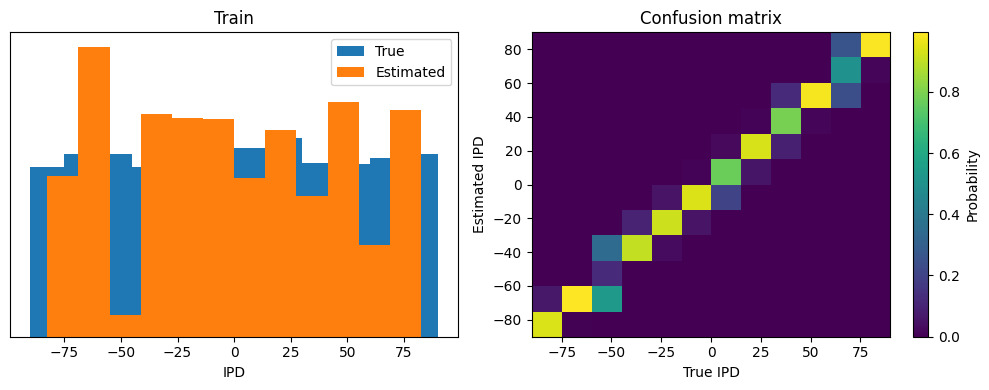

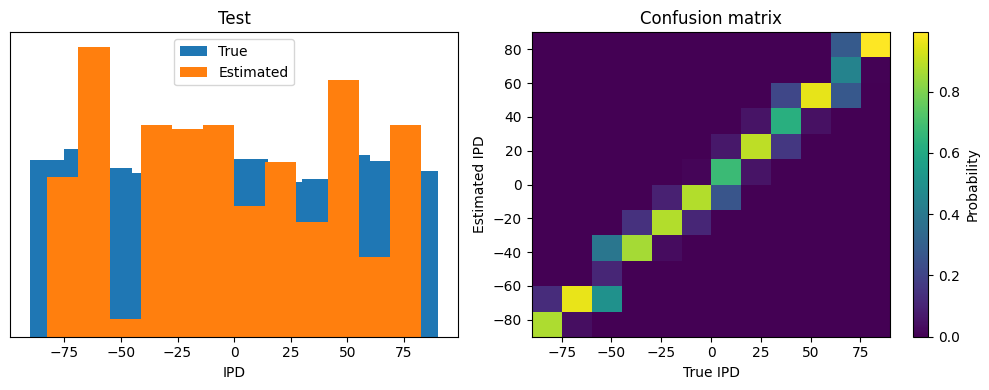

In [ ]:
# Analyse
print(f"Chance accuracy level: {100*1/num_classes:.1f}% \n")
run_func = lambda x: snn(x, W1, W2)
analyse(ipds, spikes, 'Train', run=run_func)
ipds_test, spikes_test, _ = random_ipd_input_signal(batch_size*n_testing_batches)
analyse(ipds_test, spikes_test, 'Test', run=run_func)

Yes! Performance is much better and now the confusion matrices look more like what you'd expect too. Let's take a look at the weight matrices.

### Now play with it
Change systematically some of the parameters and record the performance. You can do this for example by running the following code in a loop:

#### Example project: Envelope power




This code performs an analysis of the performance of a spiking neural network (SNN) classifier across a range of envelope power values.

Please note that the current code only plots the result of a single training session.


##### Suggestion for improvement:
  
* Run the example code from the EnvelopePower project multiple times.

* You will notice that the results vary significantly between consecutive training sessions.

* To draw robust conclusions, calculate the average across all training sessions.

* Then, plot a graph with the average and the corresponding standard deviation.

* Apply this same approach to your other projects to obtain reliable results.

Processing Envelope Powers:   0%|          | 0/11 [00:00<?, ?it/s]

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=2.92697
Epoch 2: loss=1.37214
Epoch 3: loss=1.09869
Epoch 4: loss=0.93591
Epoch 5: loss=0.84823
Epoch 6: loss=0.75888
Epoch 7: loss=0.69603
Epoch 8: loss=0.65045
Epoch 9: loss=0.61129
Epoch 10: loss=0.55629
Chance accuracy level: 8.3%
Train classifier accuracy: 82.5%
Train absolute error: 4.8 deg 



Processing Envelope Powers:   9%|▉         | 1/11 [03:56<39:29, 236.96s/it]

Test classifier accuracy: 76.9%
Test absolute error: 5.1 deg 

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=2.87620
Epoch 2: loss=1.53374
Epoch 3: loss=1.25424
Epoch 4: loss=1.09158
Epoch 5: loss=0.93145
Epoch 6: loss=0.85885
Epoch 7: loss=0.77263
Epoch 8: loss=0.72364
Epoch 9: loss=0.66430
Epoch 10: loss=0.61412
Chance accuracy level: 8.3%
Train classifier accuracy: 82.1%
Train absolute error: 4.7 deg 



Processing Envelope Powers:  18%|█▊        | 2/11 [08:07<36:42, 244.76s/it]

Test classifier accuracy: 76.0%
Test absolute error: 5.1 deg 

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=3.19659
Epoch 2: loss=1.58622
Epoch 3: loss=1.28806
Epoch 4: loss=1.09309
Epoch 5: loss=0.99393
Epoch 6: loss=0.88543
Epoch 7: loss=0.81177
Epoch 8: loss=0.74087
Epoch 9: loss=0.73595
Epoch 10: loss=0.66977
Chance accuracy level: 8.3%
Train classifier accuracy: 73.6%
Train absolute error: 5.5 deg 



Processing Envelope Powers:  27%|██▋       | 3/11 [12:42<34:30, 258.84s/it]

Test classifier accuracy: 66.3%
Test absolute error: 6.1 deg 

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=3.36784
Epoch 2: loss=1.62657
Epoch 3: loss=1.25758
Epoch 4: loss=1.05014
Epoch 5: loss=0.97161
Epoch 6: loss=0.84496
Epoch 7: loss=0.76379
Epoch 8: loss=0.70274
Epoch 9: loss=0.68481
Epoch 10: loss=0.61195
Chance accuracy level: 8.3%
Train classifier accuracy: 77.6%
Train absolute error: 5.3 deg 



Processing Envelope Powers:  36%|███▋      | 4/11 [15:55<27:09, 232.76s/it]

Test classifier accuracy: 71.3%
Test absolute error: 5.7 deg 

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=3.30373
Epoch 2: loss=1.70002
Epoch 3: loss=1.38161
Epoch 4: loss=1.17826
Epoch 5: loss=1.02657
Epoch 6: loss=0.94566
Epoch 7: loss=0.85856
Epoch 8: loss=0.79377
Epoch 9: loss=0.76147
Epoch 10: loss=0.72460
Chance accuracy level: 8.3%
Train classifier accuracy: 79.3%
Train absolute error: 5.0 deg 



Processing Envelope Powers:  45%|████▌     | 5/11 [20:37<25:02, 250.42s/it]

Test classifier accuracy: 75.4%
Test absolute error: 5.1 deg 

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=3.14422
Epoch 2: loss=1.53601
Epoch 3: loss=1.23031
Epoch 4: loss=1.04491
Epoch 5: loss=0.92425
Epoch 6: loss=0.84018
Epoch 7: loss=0.79137
Epoch 8: loss=0.69728
Epoch 9: loss=0.66969
Epoch 10: loss=0.71494
Chance accuracy level: 8.3%
Train classifier accuracy: 76.8%
Train absolute error: 5.2 deg 



Processing Envelope Powers:  55%|█████▍    | 6/11 [25:07<21:25, 257.03s/it]

Test classifier accuracy: 72.9%
Test absolute error: 5.5 deg 

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=3.09251
Epoch 2: loss=1.58461
Epoch 3: loss=1.22794
Epoch 4: loss=1.01613
Epoch 5: loss=0.89956
Epoch 6: loss=0.81194
Epoch 7: loss=0.72134
Epoch 8: loss=0.69260
Epoch 9: loss=0.63450
Epoch 10: loss=0.60616
Chance accuracy level: 8.3%
Train classifier accuracy: 74.6%
Train absolute error: 5.3 deg 



Processing Envelope Powers:  64%|██████▎   | 7/11 [29:36<17:24, 261.07s/it]

Test classifier accuracy: 72.2%
Test absolute error: 5.7 deg 

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=2.79468
Epoch 2: loss=1.32626
Epoch 3: loss=1.04382
Epoch 4: loss=0.89256
Epoch 5: loss=0.76543
Epoch 6: loss=0.69819
Epoch 7: loss=0.65807
Epoch 8: loss=0.61251
Epoch 9: loss=0.56179
Epoch 10: loss=0.52644
Chance accuracy level: 8.3%
Train classifier accuracy: 79.2%
Train absolute error: 5.0 deg 



Processing Envelope Powers:  73%|███████▎  | 8/11 [34:19<13:23, 267.96s/it]

Test classifier accuracy: 74.0%
Test absolute error: 5.3 deg 

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=3.15474
Epoch 2: loss=1.44993
Epoch 3: loss=1.16924
Epoch 4: loss=0.99302
Epoch 5: loss=0.88925
Epoch 6: loss=0.78181
Epoch 7: loss=0.74080
Epoch 8: loss=0.67064
Epoch 9: loss=0.63860
Epoch 10: loss=0.58508
Chance accuracy level: 8.3%
Train classifier accuracy: 74.5%
Train absolute error: 5.4 deg 



Processing Envelope Powers:  82%|████████▏ | 9/11 [39:00<09:04, 272.14s/it]

Test classifier accuracy: 69.7%
Test absolute error: 5.8 deg 

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=3.10394
Epoch 2: loss=1.50407
Epoch 3: loss=1.20422
Epoch 4: loss=1.00466
Epoch 5: loss=0.84500
Epoch 6: loss=0.75041
Epoch 7: loss=0.67681
Epoch 8: loss=0.63047
Epoch 9: loss=0.59018
Epoch 10: loss=0.54610
Chance accuracy level: 8.3%
Train classifier accuracy: 84.2%
Train absolute error: 4.5 deg 



Processing Envelope Powers:  91%|█████████ | 10/11 [43:48<04:37, 277.13s/it]

Test classifier accuracy: 77.5%
Test absolute error: 5.0 deg 

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=2.87228
Epoch 2: loss=1.36970
Epoch 3: loss=1.07538
Epoch 4: loss=0.92972
Epoch 5: loss=0.83979
Epoch 6: loss=0.74908
Epoch 7: loss=0.69611
Epoch 8: loss=0.66035
Epoch 9: loss=0.60702
Epoch 10: loss=0.57734
Chance accuracy level: 8.3%
Train classifier accuracy: 79.6%
Train absolute error: 5.0 deg 



Processing Envelope Powers: 100%|██████████| 11/11 [48:59<00:00, 267.23s/it]

Test classifier accuracy: 78.1%
Test absolute error: 5.0 deg 



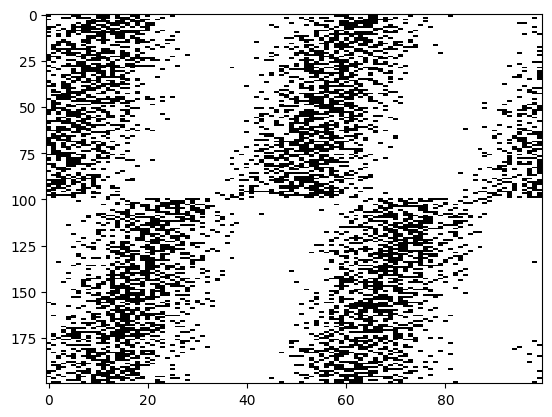

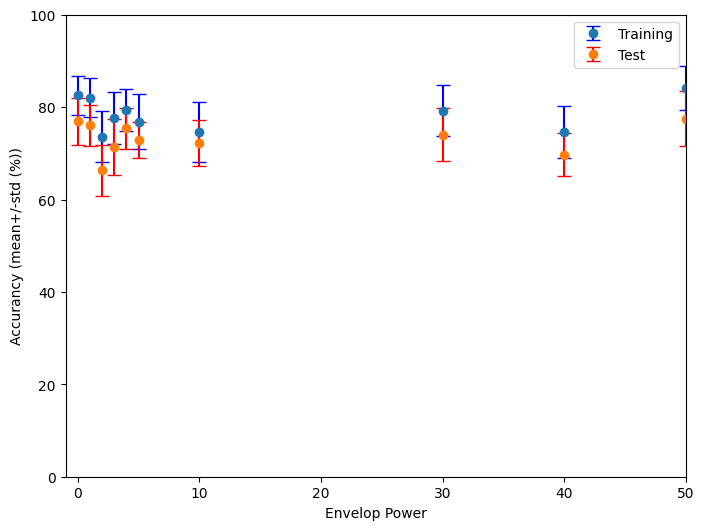

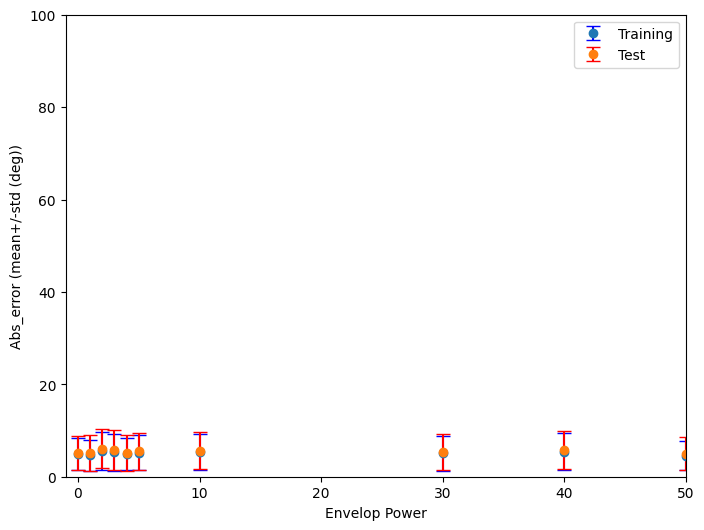

In [ ]:
from tqdm import tqdm # Import the tqdm library for displaying a progress bar

# Set training parameters
nb_epochs = 10  # Number of epochs (quick training for demonstration)
lr = 0.01       # Learning rate

# Flag for whether to plot analysis results (histograms and confusion matrises)
plot_analysis = 0 # 0:not plotting ; 1:plotting

# Define a range of envelope powers to test
Envelop_powers = [0, 1, 2, 3, 4, 5, 10, 30, 40, 50, 100]

# Initialize lists to store results for training and testing accuracy and absolute error.
# Mean and std are calulated over the different batches
Train_accuracy_mean = []   # Mean training accuracy
Train_accuracy_std = []    # Standard deviation of training accuracy
Train_abs_error_mean = []  # Mean training absolute error
Train_abs_error_std = []   # Standard deviation of training absolute error

Test_accuracy_mean = []    # Mean testing accuracy
Test_accuracy_std = []     # Standard deviation of testing accuracy
Test_abs_error_mean = []   # Mean testing absolute error
Test_abs_error_std = []    # Standard deviation of testing absolute error

results_Train = []  # Stores results from training data
results_Test = []   # Stores results from test data

# Loop through each envelope power, showing progress with tqdm
for i, envelope_power in enumerate(tqdm(Envelop_powers, desc="Processing Envelope Powers")):

    # Generate training data: interaural phase differences (IPDs) and spike data
    ipds, spikes, _ = random_ipd_input_signal(num_samples)
    plt.imshow(spikes[0, :, :].T, aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)

    # Initialize weight matrices for the neural network classifier
    W1, W2 = init_weight_matrices()

    # Define the optimizer and loss functions
    optimizer = torch.optim.Adam([W1, W2], lr=lr)
    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()

    # Print the expected initial loss
    print(f"Want loss for epoch 1 to be about {-np.log(1/num_classes):.2f}, multiply m by constant to get this")

    loss_hist = []  # Track loss over epochs
    for e in range(nb_epochs):  # Loop through each epoch
        local_loss = []  # Track batch losses for the current epoch
        for spike_batch, ipd_batch in data_generator(discretise(ipds), spikes):  # Generate data batches
            # Run the classifier on the batch
            output = snn(spike_batch, W1, W2)

            # Compute cross-entropy loss
            m = torch.sum(output, 1) * 0.01  # Aggregate output over the time dimension
            loss = loss_fn(log_softmax_fn(m), ipd_batch)
            local_loss.append(loss.item())

            # Update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Append the mean loss for the epoch
        loss_hist.append(np.mean(local_loss))
        print("Epoch %i: loss=%.5f" % (e + 1, np.mean(local_loss)))

    # Optionally plot the loss curve over epochs
    if plot_analysis:
      # Plot the loss function over time
      plt.plot(loss_hist)
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.tight_layout()


    # Analyse training data
    print(f"Chance accuracy level: {100*1/num_classes:.1f}%")

    run_func = lambda x: snn(x, W1, W2) # Define the classifier function
    results_Train = analyse(ipds, spikes, 'Train', run=run_func, plot_analysis=plot_analysis)

    # Generate and analyse test data
    ipds_test, spikes_test, _ = random_ipd_input_signal(batch_size*n_testing_batches)
    results_Test = analyse(ipds_test, spikes_test, 'Test', run=run_func, plot_analysis=0)

    # Append training results
    Train_accuracy_mean.append(results_Train[0])
    Train_accuracy_std.append(results_Train[1])
    Train_abs_error_mean.append(results_Train[2])
    Train_abs_error_std.append(results_Train[3])

    # Append testing results
    Test_accuracy_mean.append(results_Test[0])
    Test_accuracy_std.append(results_Test[1])
    Test_abs_error_mean.append(results_Test[2])
    Test_abs_error_std.append(results_Test[3])

# Plot training and testing accuracy with error bars
plt.figure(figsize=(8, 6))
plt.errorbar(Envelop_powers,Train_accuracy_mean, yerr=Train_accuracy_std, label='Training',fmt='o', ecolor='blue', capsize=5)
plt.errorbar(Envelop_powers,Test_accuracy_mean, yerr=Test_accuracy_std, label='Test', fmt='o', ecolor='red', capsize=5)
plt.ylim([0,100])
plt.xlim([-1,50])
plt.xlabel('Envelop Power')
plt.ylabel('Accurancy (mean+/-std (%))')
plt.legend()

# Plot training and testing absolute error with error bars
plt.figure(figsize=(8, 6))
plt.errorbar(Envelop_powers,Train_abs_error_mean, yerr=Train_abs_error_std, label='Training',fmt='o', ecolor='blue', capsize=5)
plt.errorbar(Envelop_powers,Test_abs_error_mean, yerr=Test_abs_error_std, label='Test', fmt='o', ecolor='red', capsize=5)
plt.ylim([0,100])
plt.xlim([-1,50])
plt.xlabel('Envelop Power')
plt.ylabel('Abs_error (mean+/-std (deg))')
plt.legend()

In [ ]:
plt.savefig("Proj_EnvelopePower.png")  # Save the plot as a PNG file

!cp Proj_EnvelopePower.png "/content/drive/My Drive/Mini-Project_ColabNotebooks/SBCP_2024/Results_Figures"

!ls "/content/drive/My Drive/Mini-Project_ColabNotebooks/SBCP_2024/Results_Figures"


### Example project 2: Weight matrix analyis

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=3.01142
Epoch 2: loss=1.55636
Epoch 3: loss=1.22104
Epoch 4: loss=1.03283
Epoch 5: loss=0.92237
Epoch 6: loss=0.82222
Epoch 7: loss=0.73452
Epoch 8: loss=0.67997
Epoch 9: loss=0.63810
Epoch 10: loss=0.59215


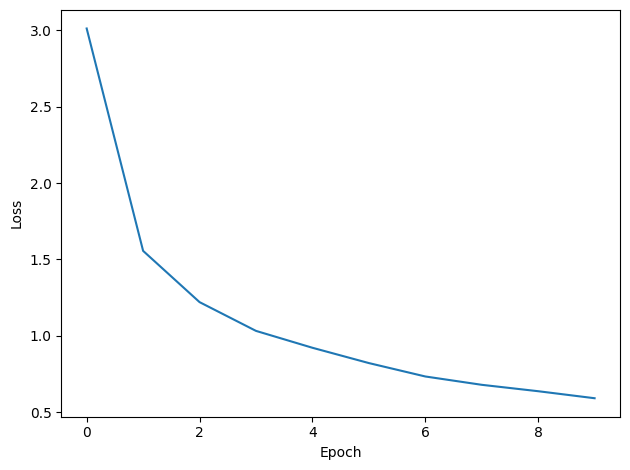

In [ ]:
# TRAINING

# Training parameters
nb_epochs = 10 # is quick, it won't have converged.
# Note: An epoch is one complete pass through the entire training dataset.
# During an epoch, the neural network processes every example in the dataset once.
# Completing an epoch means that every data point has been used for calculating the loss and updating the model parameters.
# Multiple epochs are usually required for the network to converge to an optimal set of parameters.
lr = 0.01 # learning rate

# Generate the training data
ipds, spikes, _ = random_ipd_input_signal(num_samples) # num_samples = batch_size * num_training

# Initialise a weight matrices
W1, W2 = init_weight_matrices()

# Optimiser and loss function
optimizer = torch.optim.Adam([W1, W2], lr=lr)
log_softmax_fn = nn.LogSoftmax(dim=1)
loss_fn = nn.NLLLoss()

print(f"Want loss for epoch 1 to be about {-np.log(1/num_classes):.2f}, multiply m by constant to get this")

loss_hist = []
for e in range(nb_epochs):
    local_loss = []
    for spike_batch, ipd_batch in data_generator(discretise(ipds), spikes):
        # Run network
        output = snn(spike_batch, W1, W2)

        # Compute cross entropy loss
        m = torch.sum(output, 1)*0.01  # Agregation fuction: Sum across time dimension. Note: We want loss for epoch 1 to be about -np.log(1/num_classes), multiply m by a constant to get this
        loss = loss_fn(log_softmax_fn(m), ipd_batch)
        local_loss.append(loss.item())

        # The softmax function transforms the output of a neural network's final layer into a probability
        # distribution over multiple classes in such a way that increasing the score of one class
        # decreases the probabilities of the other classes. It does this by exponentiating each logit
        # and then normalizing these values so that they sum to 1. This is important because it ensures that
        # the predicted values for each class sum up to 1.0. This probability distribution allows us to
        # interpret the network's output as the likelihood of each class being the correct class.
        # Training Objective: The training process aims to increase the probability of the correct class.
        # As the model updates its weights to increase the probability (and hence the log probability) of the
        # correct class, the softmax function inherently decreases the probabilities of the other classes due
        # to the normalization step.
        # Using it with the negative log likelihood loss encourages the model to increase the log probability
        # of the correct class.
        # Interpretability: The softmax function's output can be interpreted as class probabilities, which is
        # valuable not only for making predictions but also for understanding the model's confidence in those
        # predictions. This can be useful for post-processing or decision-making based on the network's output
        # probabilities.

        # Update gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_hist.append(np.mean(local_loss))
    print("Epoch %i: loss=%.5f"%(e+1, np.mean(local_loss)))

# Plot the loss function over time
plt.plot(loss_hist)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()


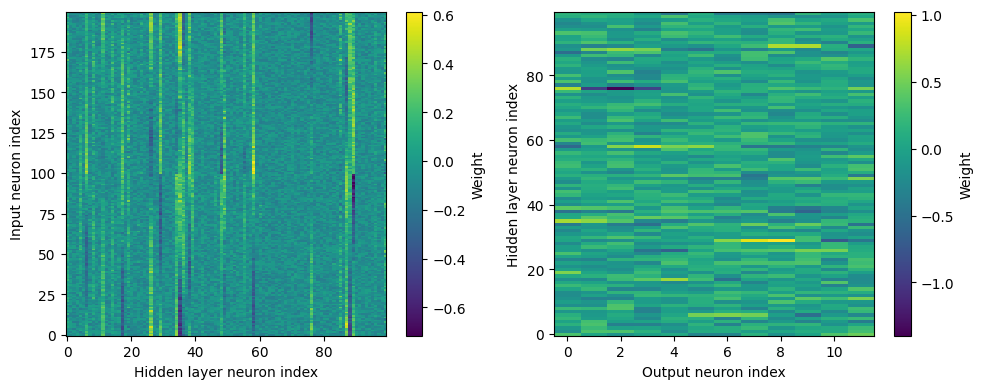

In [ ]:
plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(121)
plt.imshow(W1.detach().cpu().numpy(), interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Input neuron index')
plt.xlabel('Hidden layer neuron index')
plt.colorbar(label="Weight")
plt.subplot(122)
plt.imshow(W2.detach().cpu().numpy(), interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Hidden layer neuron index')
plt.xlabel('Output neuron index')
plt.colorbar(label="Weight")
plt.tight_layout()

In [ ]:
W2_ = W2.detach().cpu().numpy()
W2_.shape
print(f"W2_.shape: {W2_.shape}")
print(f"W2_01")
print(f"")

(100, 12)

Hmm, hard to interpret.

**Exercise.** Any ideas?

Here's what Dan Goodmann got so far...

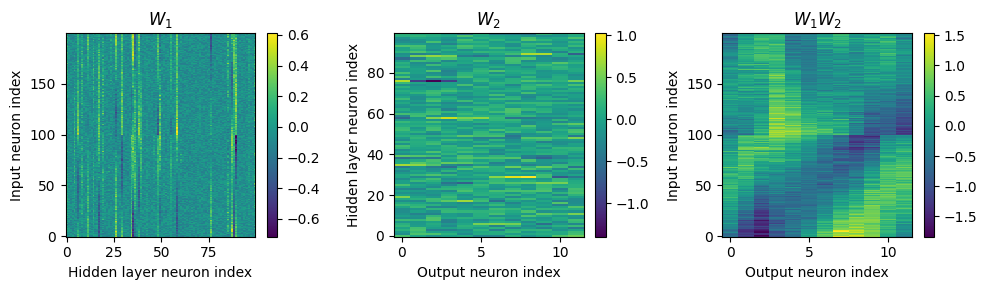

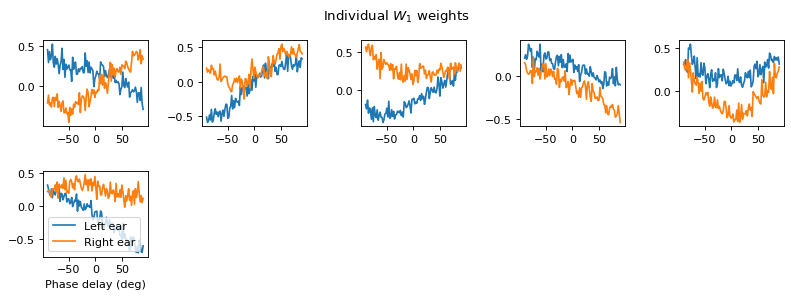

In [ ]:
w1 = W1.detach().cpu().numpy()
w2 = W2.detach().cpu().numpy()

# for each column of w1, compute the weighted mean and re-order according to that
A = np.arange(w1.shape[0])[:, None]
weighted_mean = np.mean((A*w1), axis=0)
weighted_mean[np.max(np.abs(w1), axis=0)<.5] = np.inf
I = np.argsort(weighted_mean)
#w1 = w1[:, I]
#w2 = w2[I, :]

# Plot the re-ordered weight matrices
plt.figure(figsize=(10, 3), dpi=100)
plt.subplot(131)
plt.imshow(w1, interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Input neuron index')
plt.xlabel('Hidden layer neuron index')
plt.title('$W_1$')
plt.colorbar()
plt.subplot(132)
plt.imshow(w2, interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Hidden layer neuron index')
plt.xlabel('Output neuron index')
plt.title('$W_2$')
plt.colorbar()
plt.subplot(133)
plt.imshow(w1@w2, interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Input neuron index')
plt.xlabel('Output neuron index')
plt.title('$W_1W_2$')
plt.colorbar()
plt.tight_layout()

# Plot some sample weights for hidden neurons
I_nz, = (np.max(np.abs(w1), axis=0)>.5).nonzero()
plt.figure(figsize=(10, 5), dpi=80)
phi = np.linspace(-np.pi/2, np.pi/2, w1.shape[0]//2)
for i, j in list(enumerate(I_nz))[:15]:
    plt.subplot(3, 5, i+1)
    plt.plot(phi*180/np.pi, w1[:w1.shape[0]//2, j], label="Left ear")
    plt.plot(phi*180/np.pi, w1[w1.shape[0]//2:, j], label="Right ear")
plt.suptitle("Individual $W_1$ weights")
plt.legend(loc='best')
plt.xlabel('Phase delay (deg)')
plt.tight_layout()

# Make a collection of functions and their docstrings that are defined in this notebook.

In [ ]:
import inspect

def example_function1():
    """This is a docstring for example_function1."""
    pass

def example_function2():
    """This is a docstring for example_function2."""
    pass

# Extracting names and docstrings of user-defined functions
functions_info = {name: obj.__doc__ for name, obj in globals().items() if inspect.isfunction(obj)}

# Displaying names and docstrings
for name, doc in functions_info.items():
    print(f"Function Name: {name}\nDescription: {doc}\n{'-'*40}")


Function Name: input_signal
Description: 
  Generate a Poisson spike train based on an input Interaural Phase Difference (IPD) array
  and the delays imposed by the individual auditory nerve fibers.

    Parameters
    ----------
    ipd : array-like
        An array of true Interaural Phase Differences (IPD). Shape: (num_samples, )

    Returns
    -------
    spikes : ndarray
        A binary array indicating spike occurrences, shaped (num_samples, duration_steps, 2*anf_per_ear).
        `spikes[i, j, k]` is 1 if a spike occurred at the jth time step for the ith IPD in the kth auditory nerve fiber,
        and 0 otherwise.

    Notes
    -----
    - The function first calculates an array of phases (`phi`) to define the sinudoidal auditory stimulus and adds a random
    phase offset because we want that the system learns to infer the angular location of the sound source indepent of its distance
    to the source.
    - An array of theta values is initialized that will hold the transfo